# Análisis Predictivo de Series Temporales

-----

## Predicción utilizando el modelo completo



## Objetivo:

Mostrar un caso de análisis completo para ver el tema predicción en la serie original luego de analizarla mediante cambios de variable.

Utilizaremos la biblioteca `astsa`  como hasta ahora, y en algunos casos la biblioteca `forecast` que tiene algunas funciones que simplifican este proceso.

In [2]:
#install.packages("forecast")
library(forecast)

In [3]:
#install.packages("astsa")
library(astsa)

options(repr.plot.width=15, repr.plot.height=8) #ajusta tamaño de graficas



Attaching package: 'astsa'


The following object is masked from 'package:forecast':

    gas




## Ejemplo 1: La serie de Johnson y Johnson

Este ejemplo se grafica a continuación, y consituye la serie de ganancias trimestrales de Johnson y Johnson

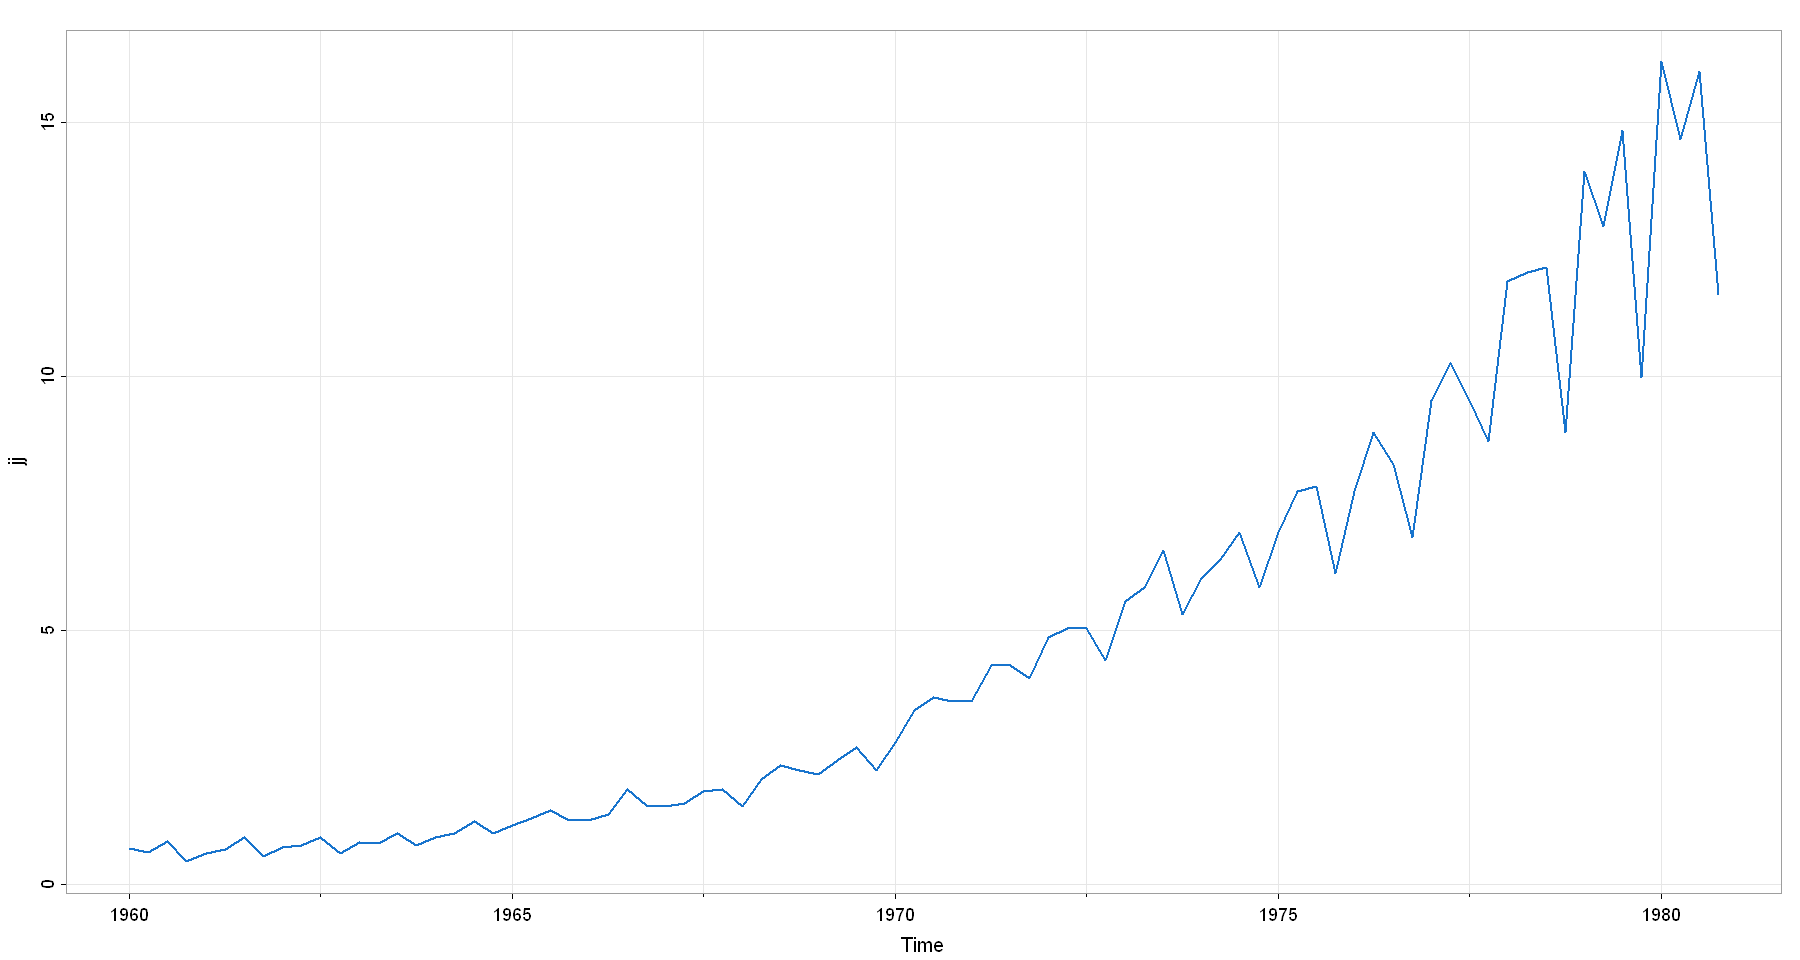

In [4]:
tsplot(jj, lwd=2, col=4)

### Transformación de variables

La serie anterior muestra variaciones en varias escalas por lo que es razonable aplicar una transformación Box-Cox o por ejemplo `log`. Trabajaremos con la serie $x = \log(jj)$.

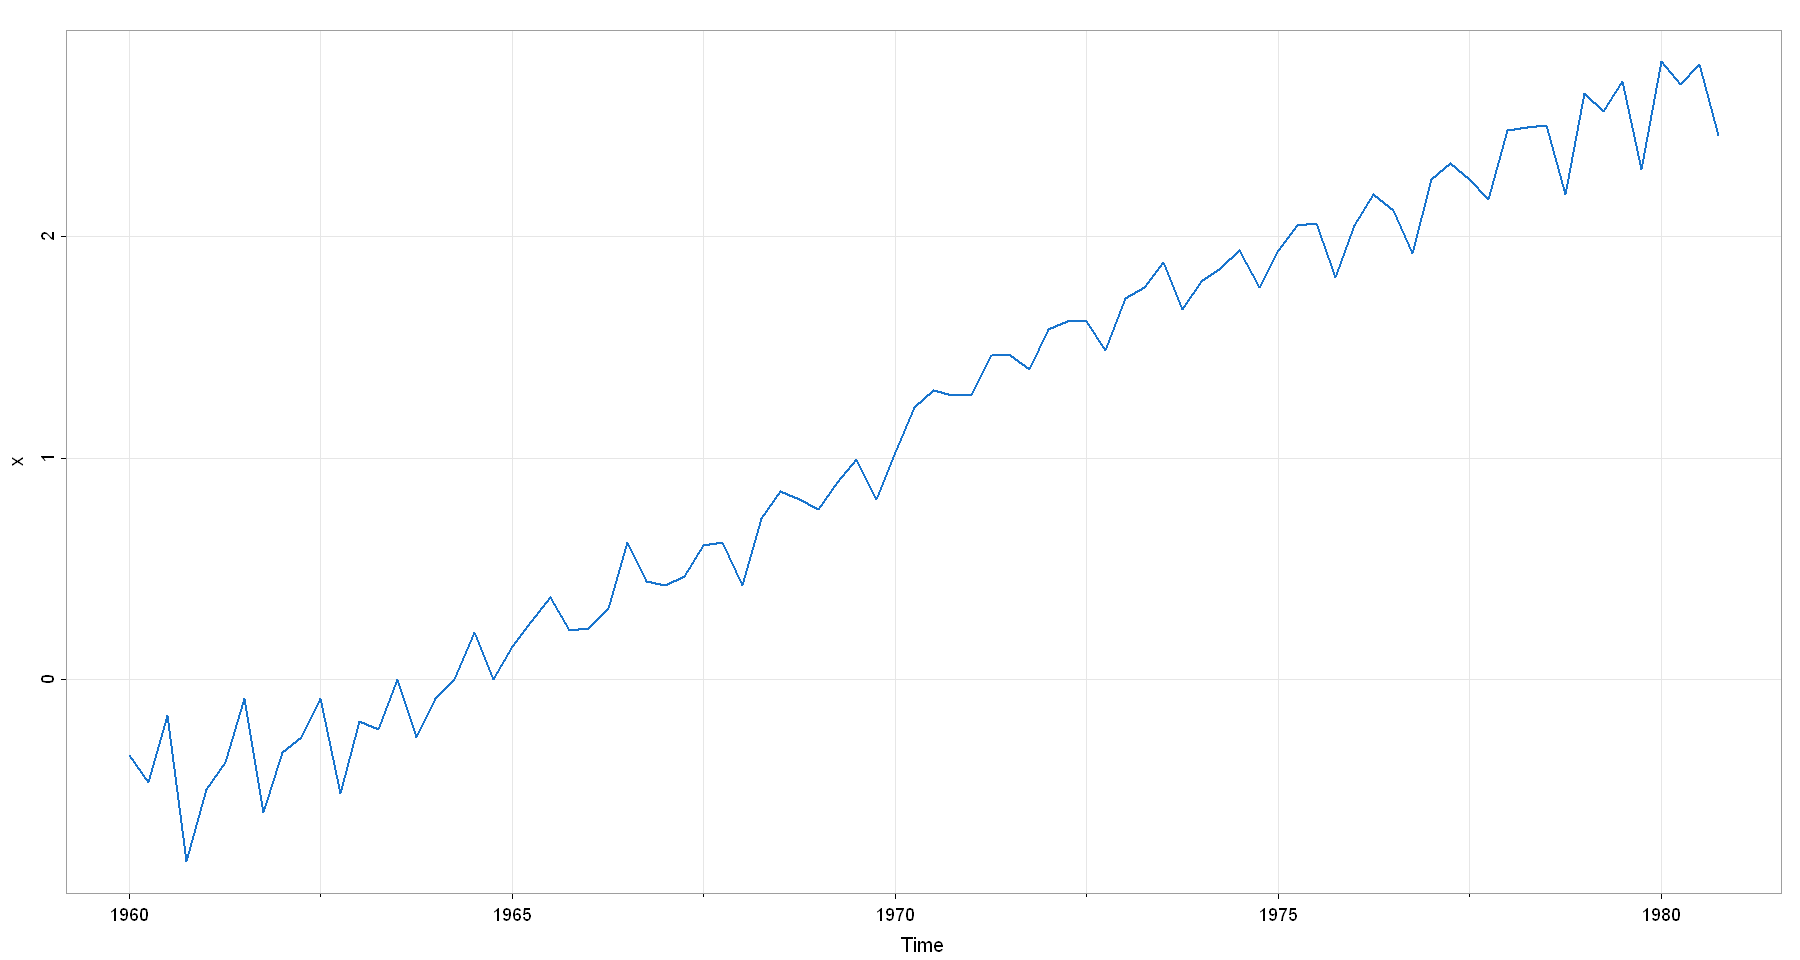

In [5]:
x=log(jj)
tsplot(x, lwd=2, col=4)

### Analisis estacional

La serie presenta una tendencia creciente (aproximadamente lineal) más un efecto trimestral bien marcado. Hacemos una regresión lineal tomando como eje de tiempos los años centrados en 1970 y factores trimestrales.

In [6]:
season =factor(cycle(jj))
t=time(x)-1970
fit1 = lm(x~t+season)
summary(fit1)


Call:
lm(formula = x ~ t + season)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.29318 -0.09062 -0.01180  0.08460  0.27644 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.052793   0.027359  38.480  < 2e-16 ***
t            0.167172   0.002259  73.999  < 2e-16 ***
season2      0.028123   0.038696   0.727   0.4695    
season3      0.098231   0.038708   2.538   0.0131 *  
season4     -0.170527   0.038729  -4.403 3.31e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1254 on 79 degrees of freedom
Multiple R-squared:  0.9859,	Adjusted R-squared:  0.9852 
F-statistic:  1379 on 4 and 79 DF,  p-value: < 2.2e-16


Del análisis anterior surge que:

 * La recta central $y=\beta_0 + \beta_1 t$ es claramente significativa.
 * El factor del trimestre 4 es significativo, y un poco menos el del trimestre
3.
 * El factor del trimestre 1 se omite porque está contenido en el intercept (no es independiente de los otros). Esto lo hace automáticamente `R`.
 
Para poder plotear el ajuste, tenemos que convertir los valores a serie temporal. A su vez, para analizar los residuos debemos hacer lo mismo.

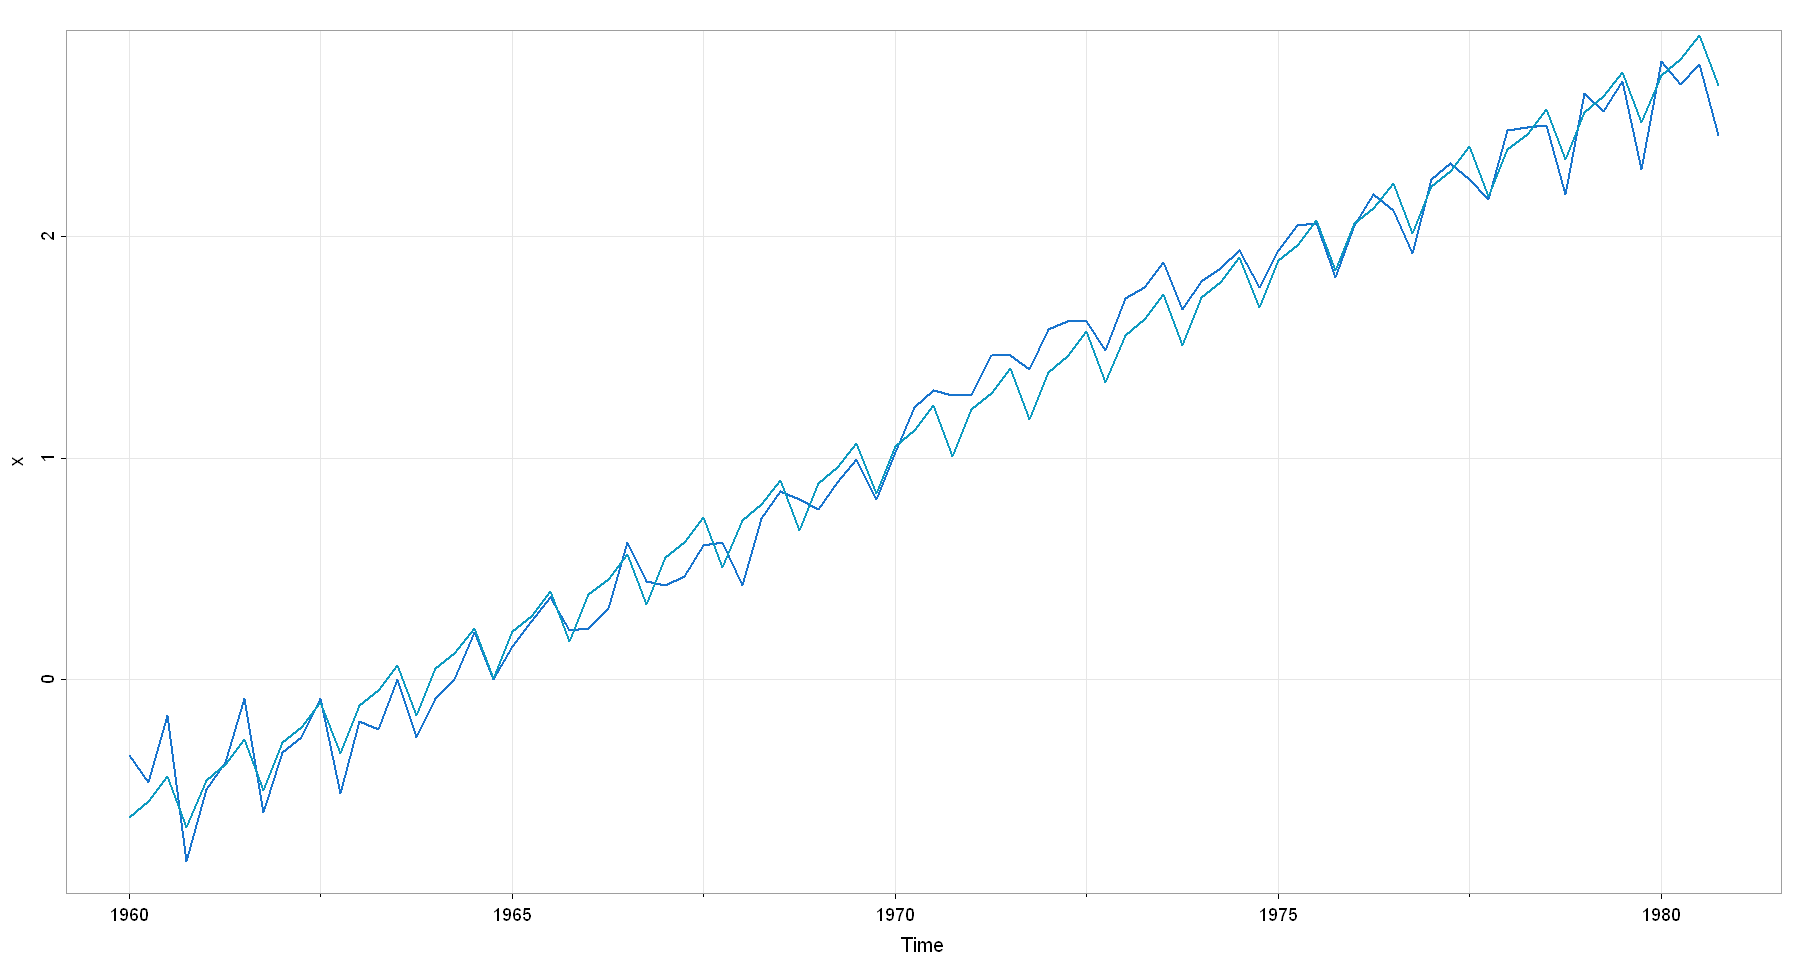

In [7]:
##genero una serie temporal sincronizada con x con las predicciones del modelo lineal
ajuste = ts(fitted(fit1),start=1960,freq=4)

#ploteo
tsplot(x,lwd=2, col=4)
lines(ajuste, lwd=2, col=5)

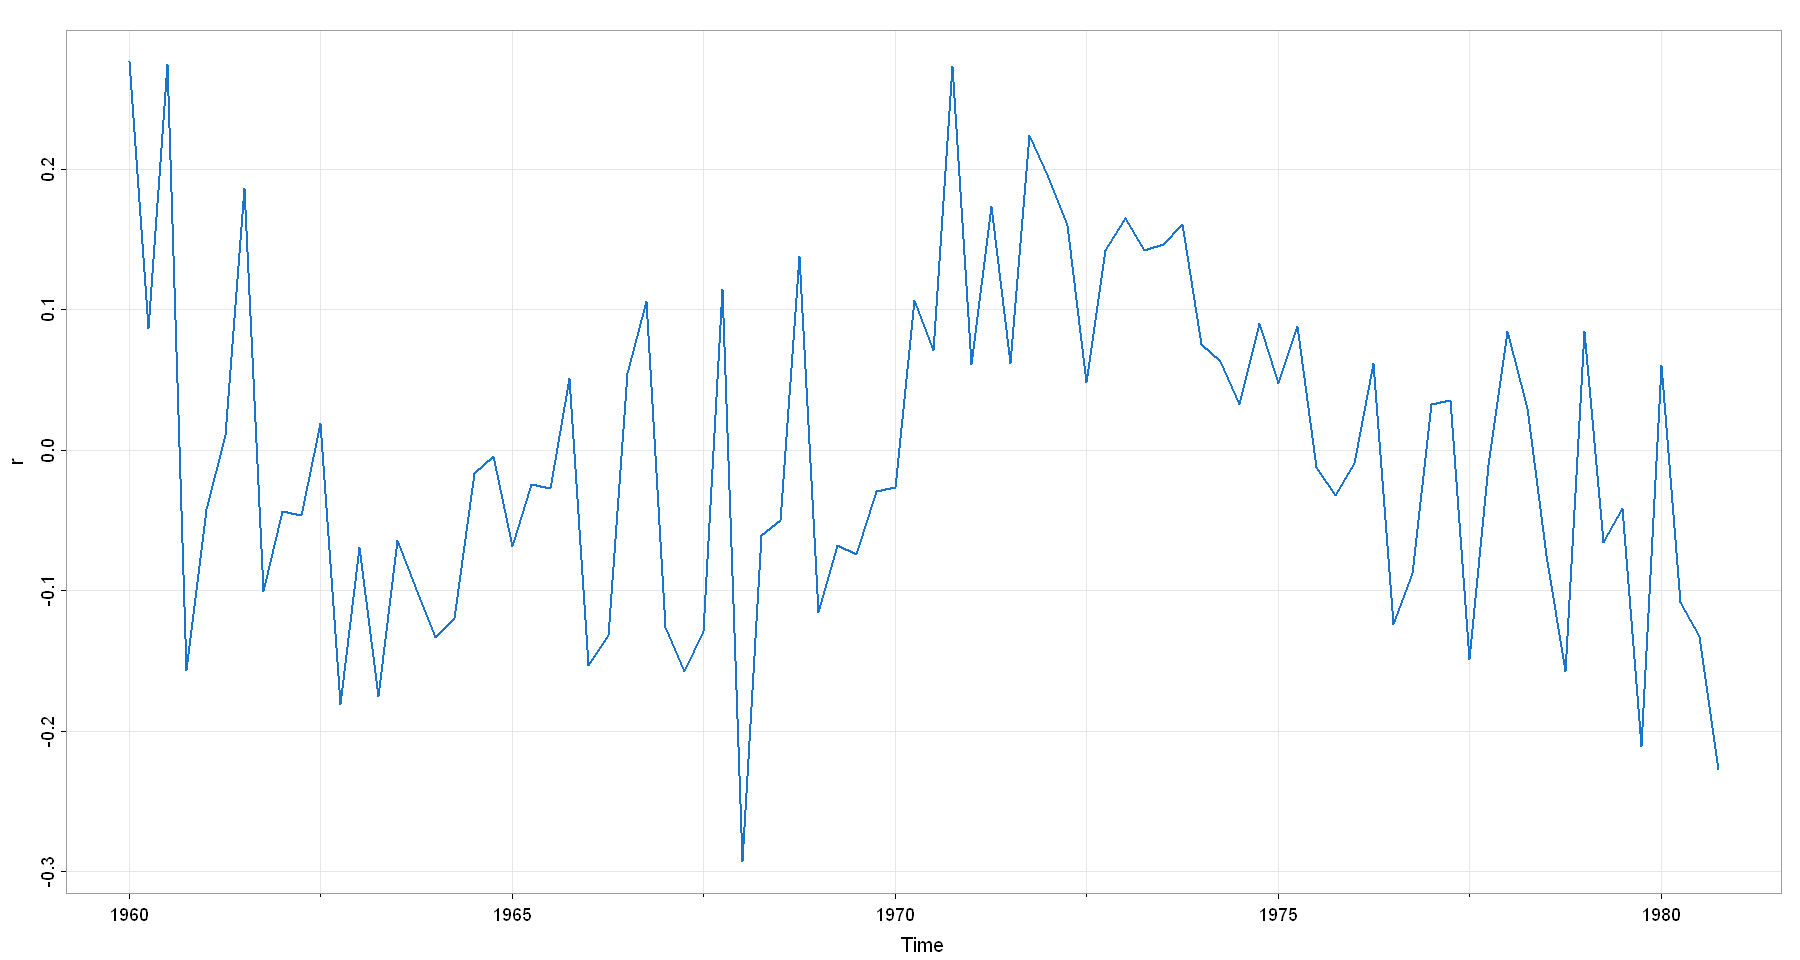

In [8]:
#Genero una serie temporal con los valores de los residuos y ploteo
r=ts(residuals(fit1),start=1960,freq=4)
tsplot(r, lwd=2, col=4)

### Predicción usando el ajuste de tendencia y estacionalidad (el `lm`)

Para continuar la predicción dada por el resultado del `lm`, debemos ahora generar nuevos puntos del tiempo donde evaluar el modelo. Estos puntos de tiempo tienen que ser la *continuación* de las series $t$ y $season$ en este caso. En general, tienen que ser la continuación de todos los regresores que se hayan usado.

In [11]:
## Construimos los nuevos datos a evaluar el modelo

#Agregamos tiempos para 4 años en el futuro. Notar el -1970 para que quede igual que la que ajustamos.
new_t = seq(1981,1984.75,by=0.25) - 1970
#Lo convierto en serie temporal
new_t = ts(new_t,start=1981,freq=4)
#Le agrego los factores
new_season = factor(cycle(new_t))

#Predigo sobre los nuevos datos.
new_data = data.frame(t=new_t,season=new_season)
prediccion= predict(fit1, new_data);

#Convierto el resultado en time series
prediccion = ts(prediccion,start=1981,freq=4)
prediccion

,Qtr1,Qtr2,Qtr3,Qtr4
1981,2.891687,2.961603,3.073504,2.846539
1982,3.058859,3.128775,3.240676,3.013712
1983,3.226031,3.295947,3.407848,3.180884
1984,3.393203,3.463119,3.575021,3.348056


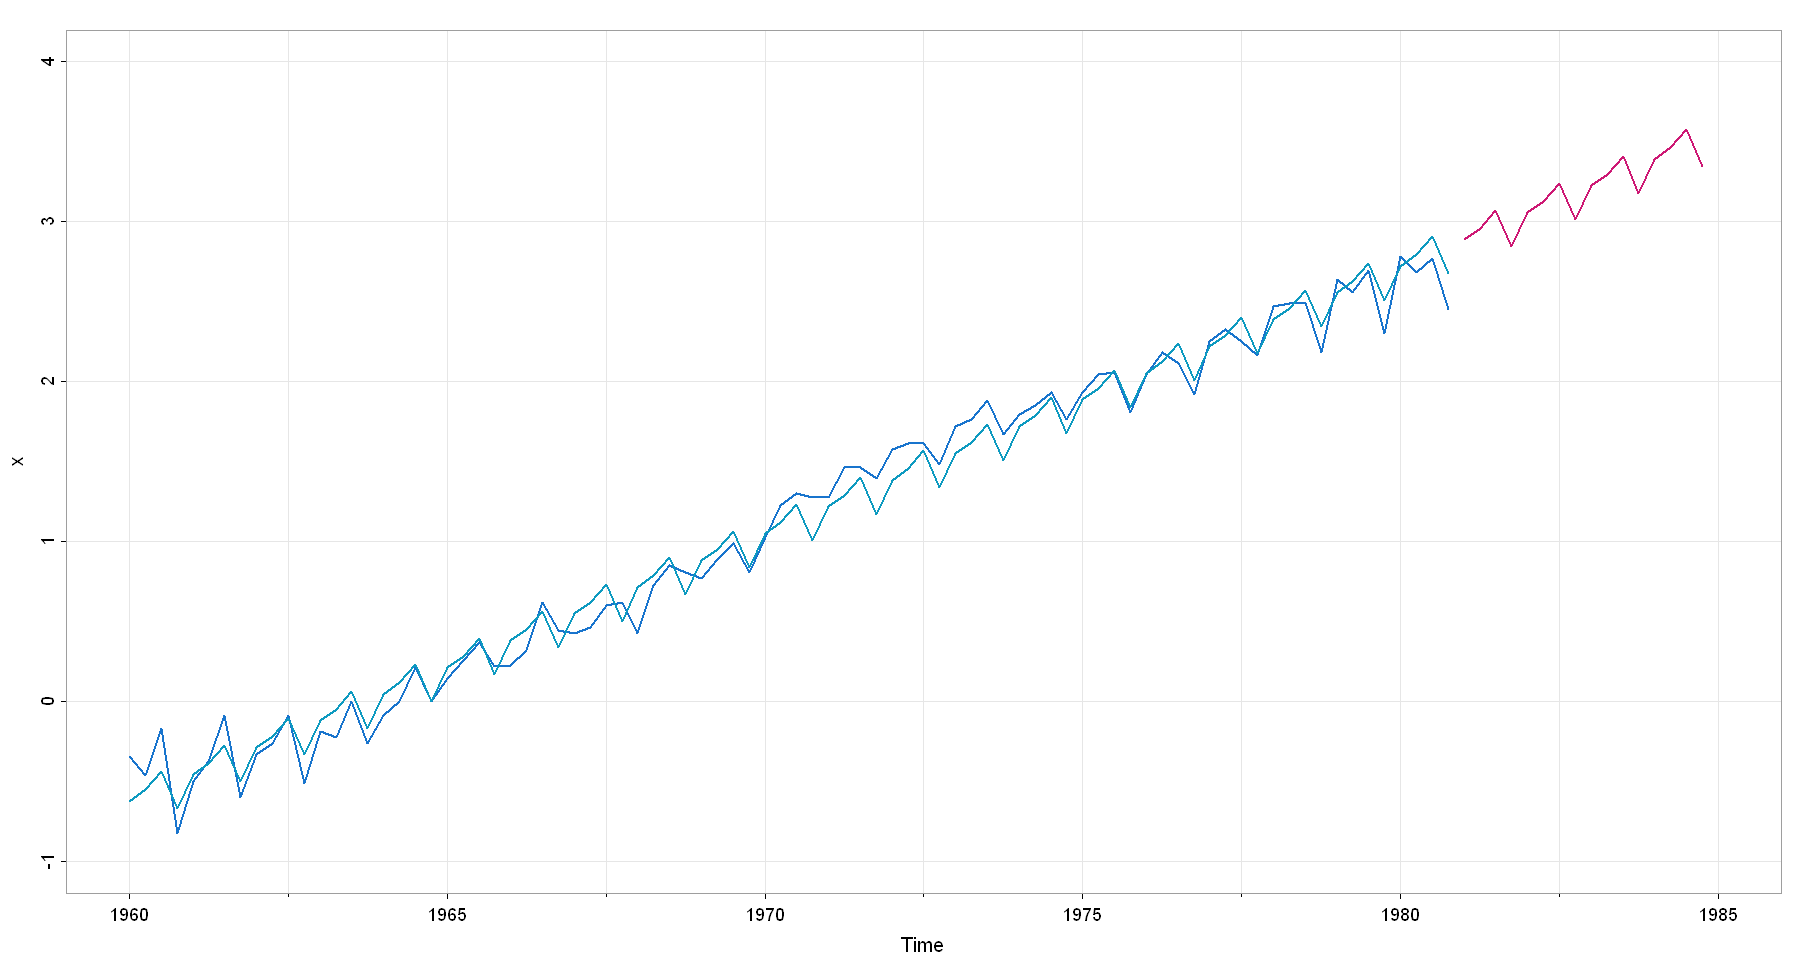

In [12]:
tsplot(x,xlim=c(1960,1985),ylim=c(-1,4), lwd=2, col=4)
lines(ajuste,lwd=2, col=5)
lines(prediccion,lwd=2, col=6)

### Volviendo a la variable original

La predicción anterior incluye media e intervalos de confianza, pero es en la variable `log(jj)`. ¿Cómo podemos graficar la predicción en la variable original?

Debemos deshacer el cambio de variable. Si queremos recuperar la media debemos hacer `exp`

,Qtr1,Qtr2,Qtr3,Qtr4
1981,18.02369,19.32893,21.61752,17.22806
1982,21.30324,22.84597,25.55099,20.36284
1983,25.17953,27.00298,30.20020,24.06801
1984,29.76114,31.91638,35.69535,28.44738


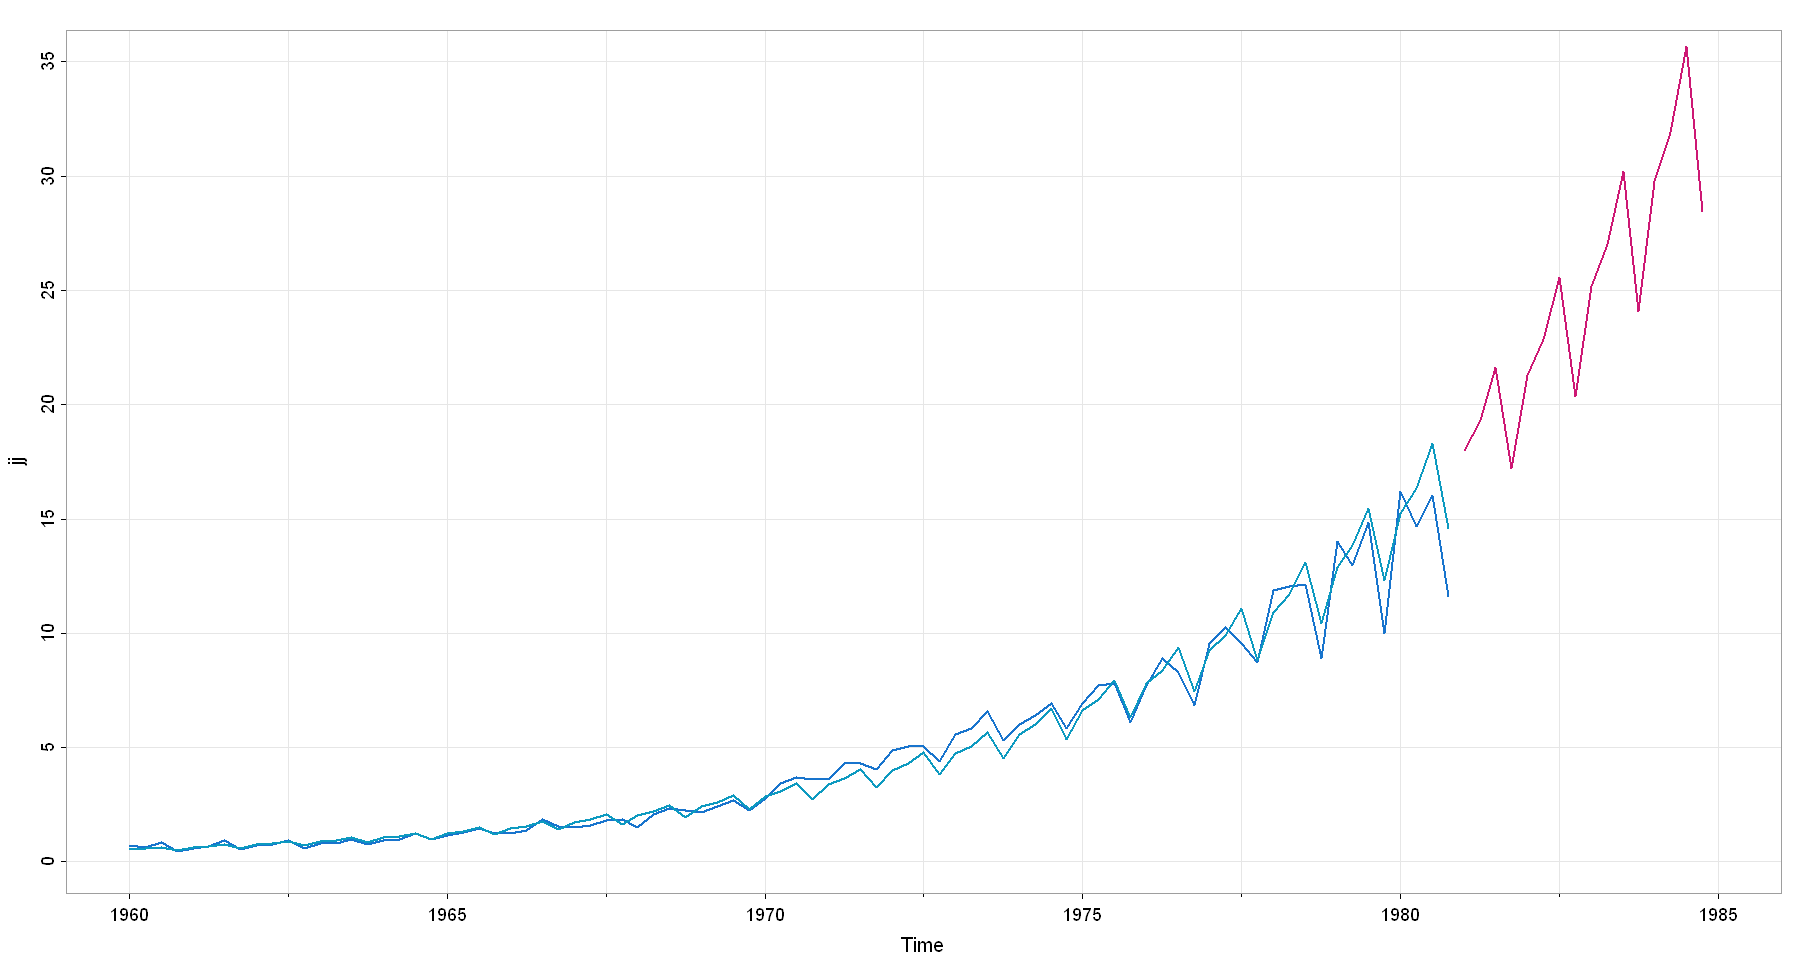

In [14]:
ajuste_original = exp(ajuste)
pred_original = exp(prediccion)

tsplot(jj,xlim=c(1960,1985),ylim=c(0,35), col=4, lwd=2)
lines(ajuste_original,col=5, lwd=2)
lines(pred_original,col=6, lwd=2)
pred_original

### Ajuste con menos factores estacionales

El ajuste anterior incluye cuatro factores estacionales. No todos los factores son significativos. Podemos intentar ajustar usando "menos dummies", es decir, solo la de season 4 por ejemplo.

Debemos reconstruir luego la serie.

#### Ajustando las dummies

Supongamos que queremos incluir un factor solo para el trimestre 4 que es el distinto. Tenemos que generar la variable para el modelo lineal como sigue.


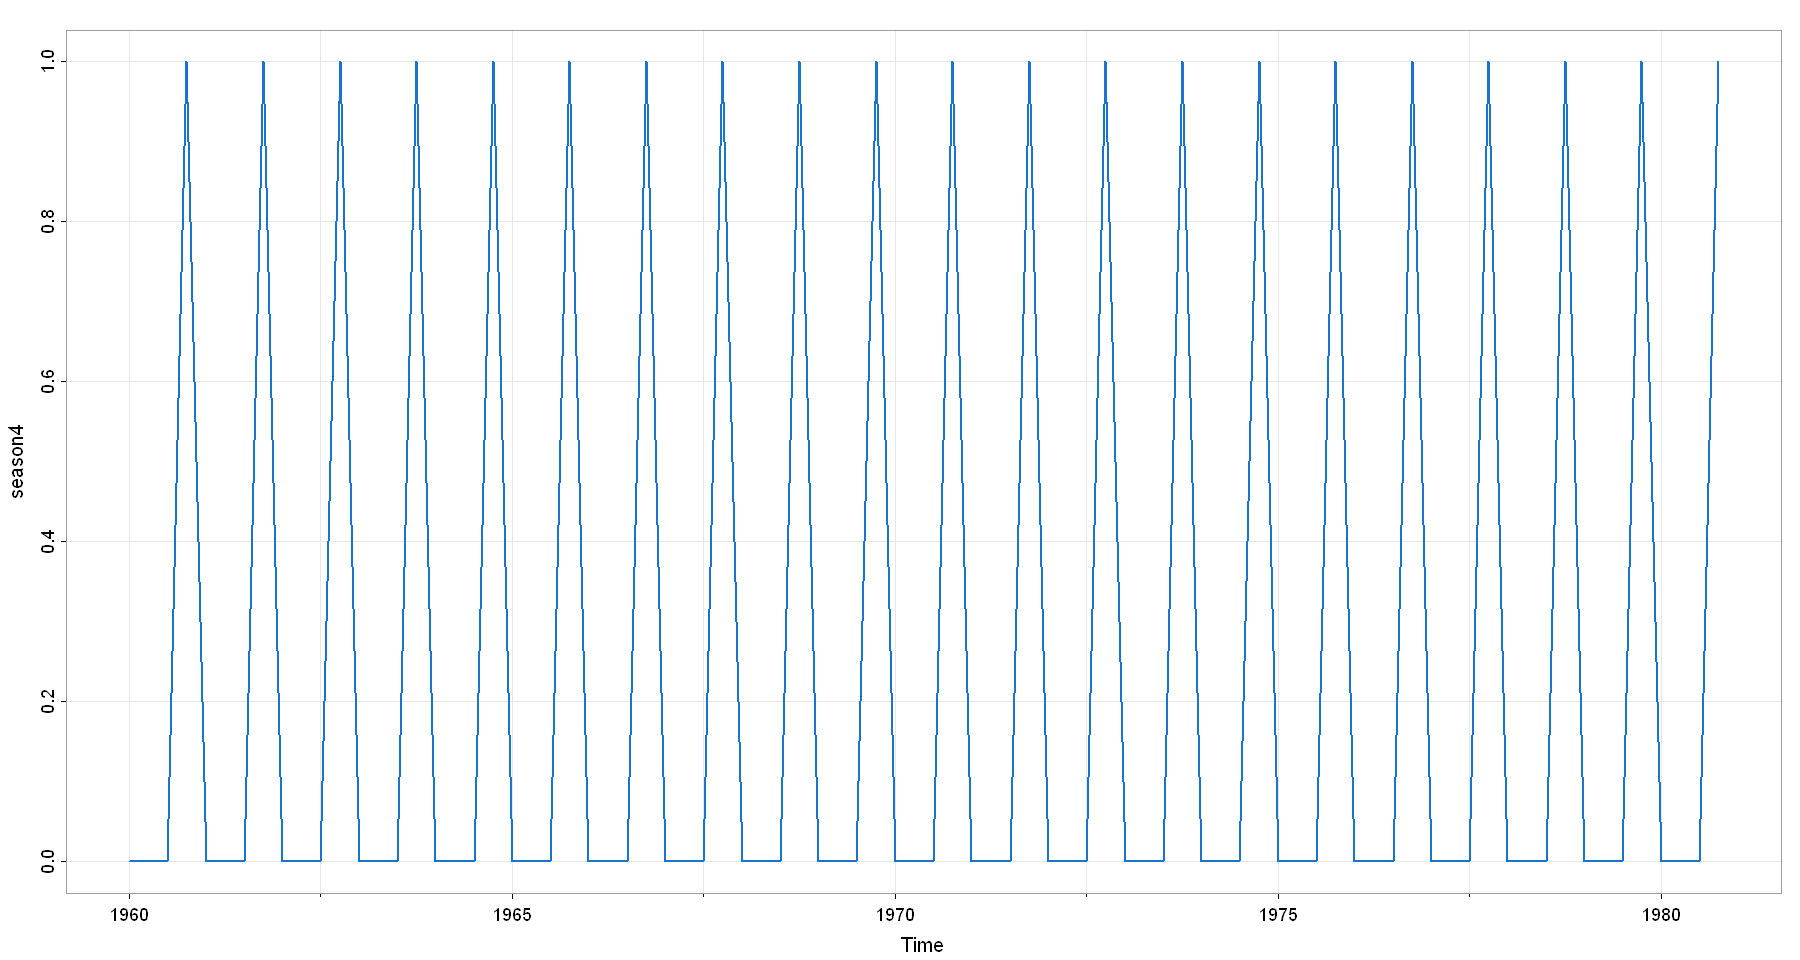

In [15]:
#Armo la variable indicadora del trimestre 4 "a mano"
season4 = rep(c(0,0,0,1),length(x)/4)
season4 = ts(season4,start=1960,frequency=4)

tsplot(season4, col=4, lwd=2)

In [16]:
fit2 = lm(x~ t + season4)
summary(fit2)


Call:
lm(formula = x ~ t + season4)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.33492 -0.08572  0.00129  0.09031  0.33234 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.094869   0.016271  67.291  < 2e-16 ***
t            0.167339   0.002325  71.988  < 2e-16 ***
season4     -0.212728   0.032541  -6.537 5.19e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1291 on 81 degrees of freedom
Multiple R-squared:  0.9847,	Adjusted R-squared:  0.9843 
F-statistic:  2599 on 2 and 81 DF,  p-value: < 2.2e-16


Nótese que ahora todos los coeficientes se vuelven significativos, mientras que el error estándar se mantiene aproximadamente incambiado.

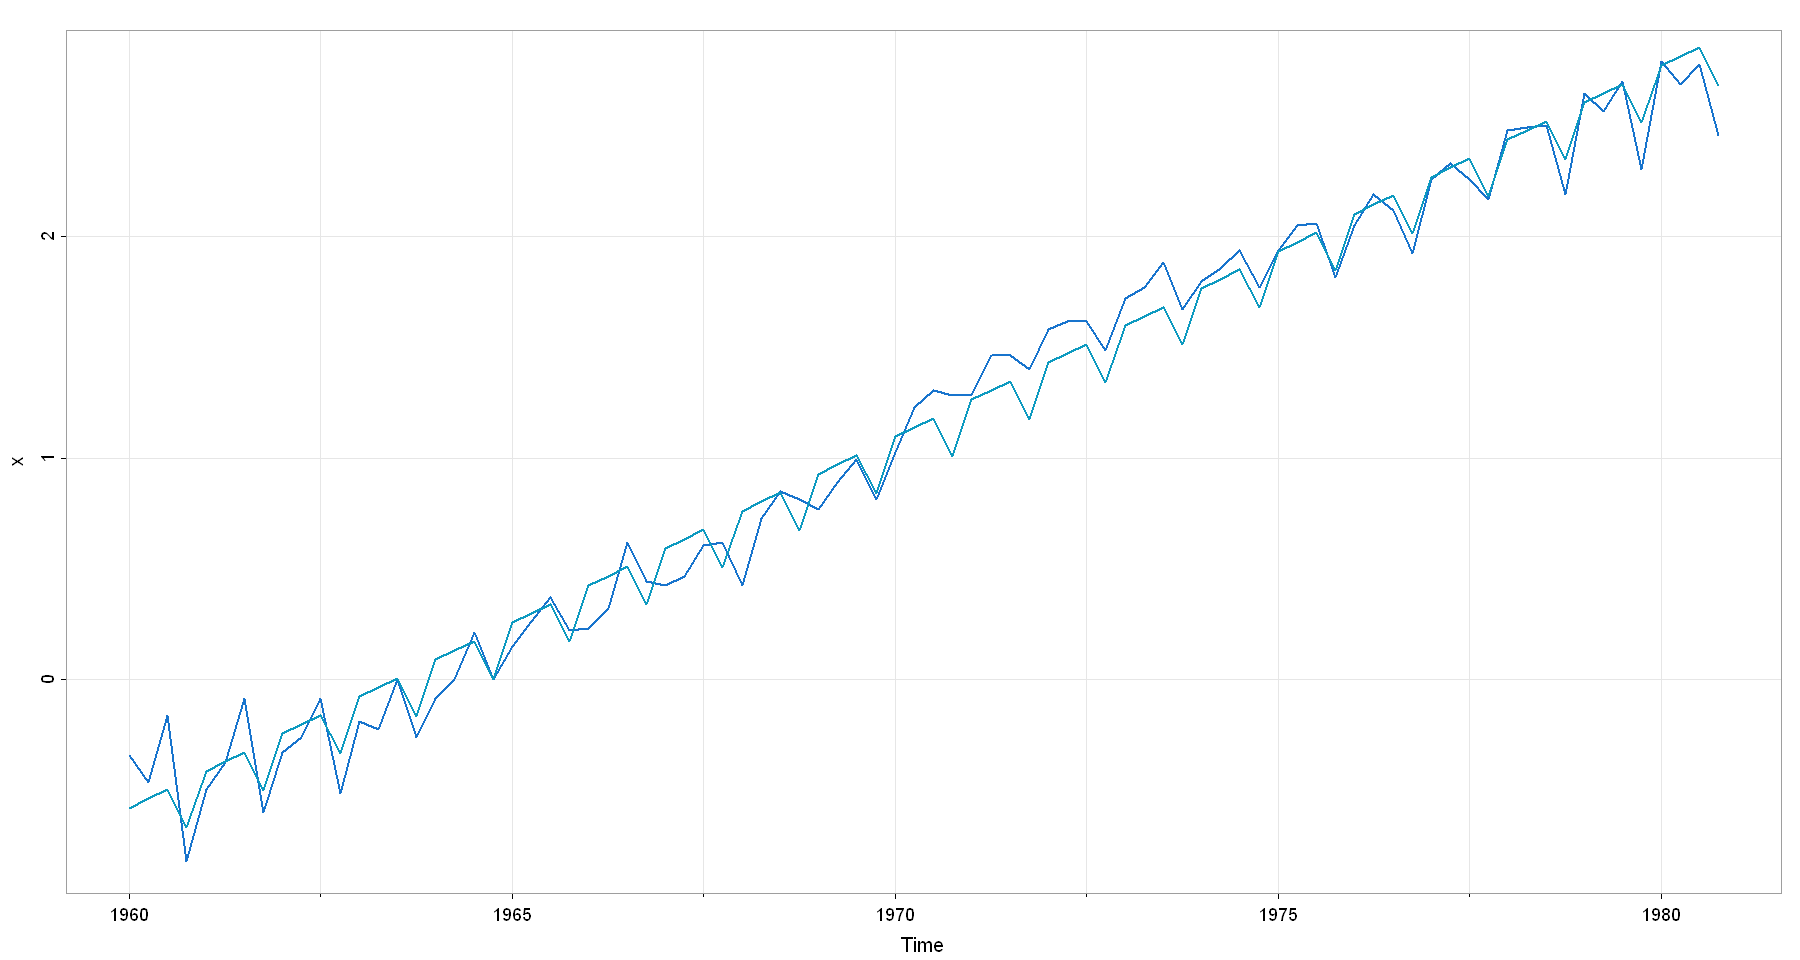

In [17]:
##genero una serie temporal sincronizada con x con las predicciones del modelo lineal
ajuste2 = ts(fitted(fit2),start=1960,freq=4)

#ploteo
tsplot(x, col=4, lwd=2)
lines(ajuste2, col=5, lwd=2)

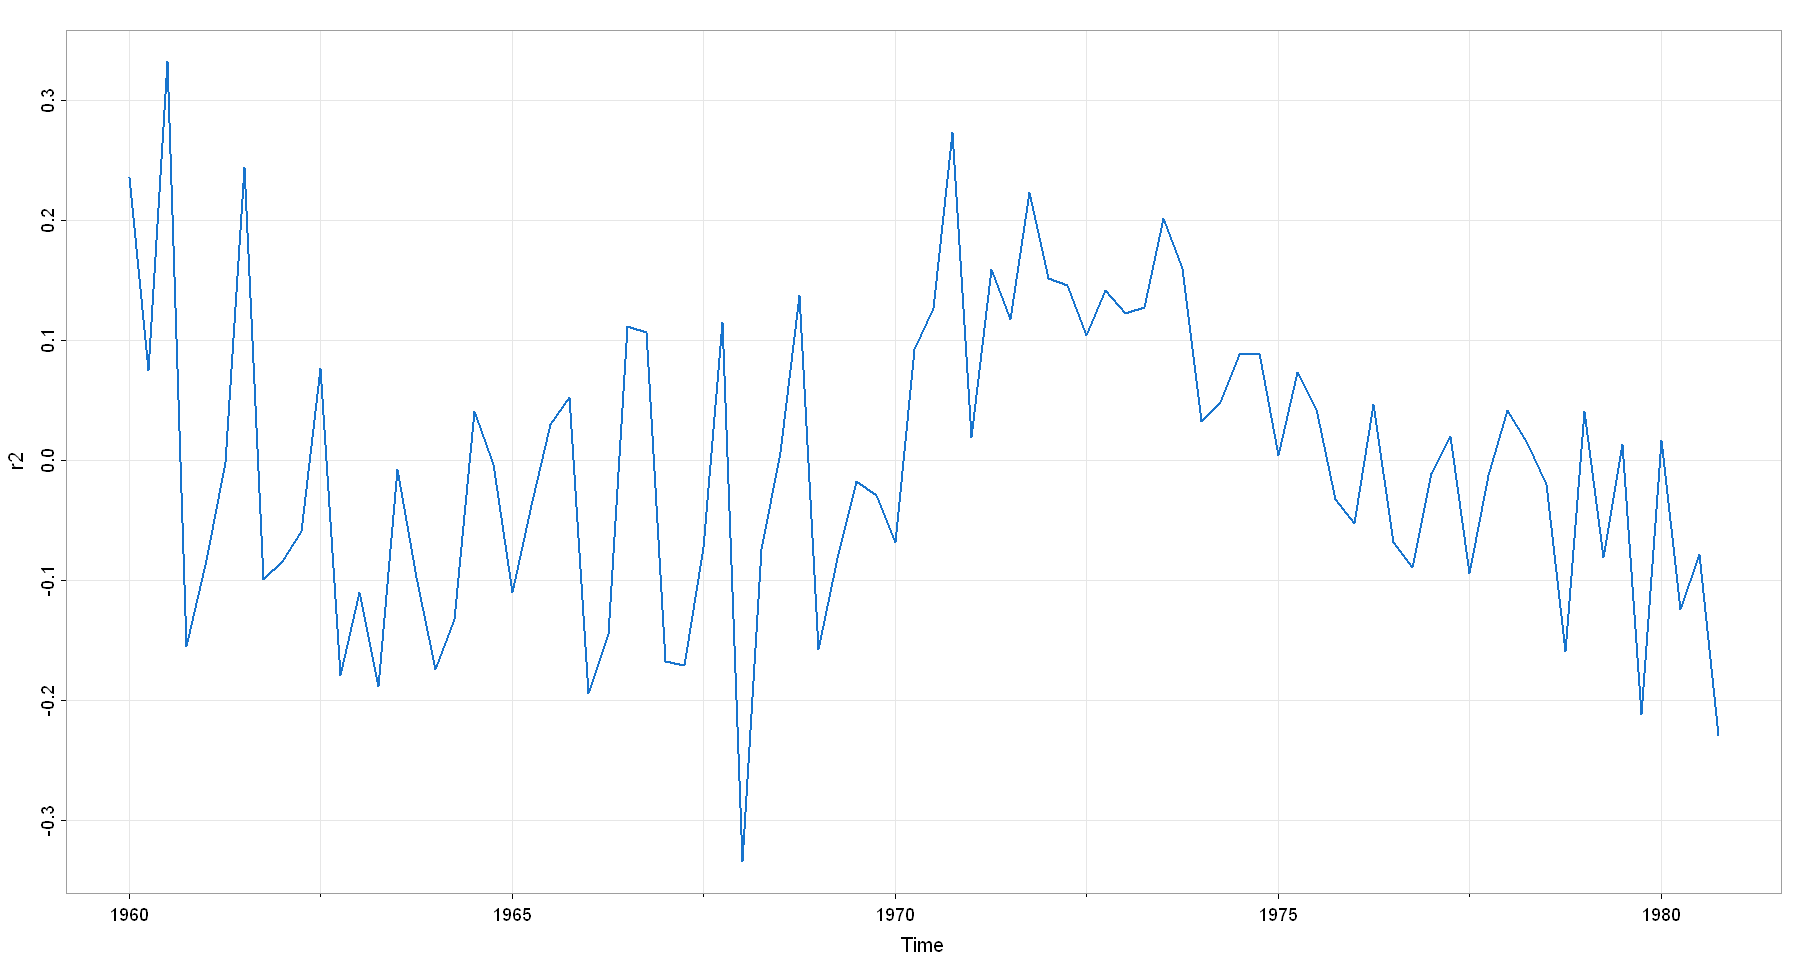

In [18]:
#Genero una serie temporal con los valores de los residuos y ploteo
r2=ts(residuals(fit2),start=1960,freq=4)
tsplot(r2, lwd=2, col=4)

In [19]:
#La funcion sigma extrae el RMSE del ajuste
RMSE_1 = sigma(fit1)
RMSE_2 = sigma(fit2)

RMSE_1
RMSE_2

[1] 0.1253757

[1] 0.1290615

Es decir, el ajuste es similar pero el segundo modelo tiene dos parámetros menos. Esto se refleja en el AIC y BIC 

In [20]:
AIC_1 = AIC(fit1)
AIC_2 = AIC(fit2)
BIC_1 = BIC(fit1)
BIC_2 = BIC(fit2)

AIC_1
AIC_2
BIC_1
BIC_2

[1] -103.6153

[1] -100.6475

[1] -89.03043

[1] -90.92421

El primer modelo es levemente mejor con este criterio. De todos modos puede ser una buena idea mantenerse en el segundo. Sigamos explorandolo. El siguiente paso es reconstruir la predicción en la serie original continuando la dummy de season4.

In [23]:
## Construimos los nuevos datos a evaluar el modelo

#Agregamos tiempos para 4 años en el futuro. Notar el -1970 para que quede igual que la que ajustamos.
new_t = seq(1981,1984.75,by=0.25) - 1970
#Lo convierto en serie temporal
new_t = ts(new_t,start=1981,freq=4)
#Le agrego el factor cada cuatro lugares
new_season4 = rep(c(0,0,0,1),length(new_t)/4)

#Predigo sobre los nuevos datos.
new_data = data.frame(t=new_t,season4=new_season4)
prediccion2= predict(fit2, new_data);

#Convierto el resultado en time series
prediccion2 = ts(prediccion2,start=1981,freq=4)
prediccion2

,Qtr1,Qtr2,Qtr3,Qtr4
1981,2.935603,2.977438,3.019273,2.848380
1982,3.102943,3.144778,3.186613,3.015719
1983,3.270282,3.312117,3.353952,3.183059
1984,3.437622,3.479457,3.521291,3.350398


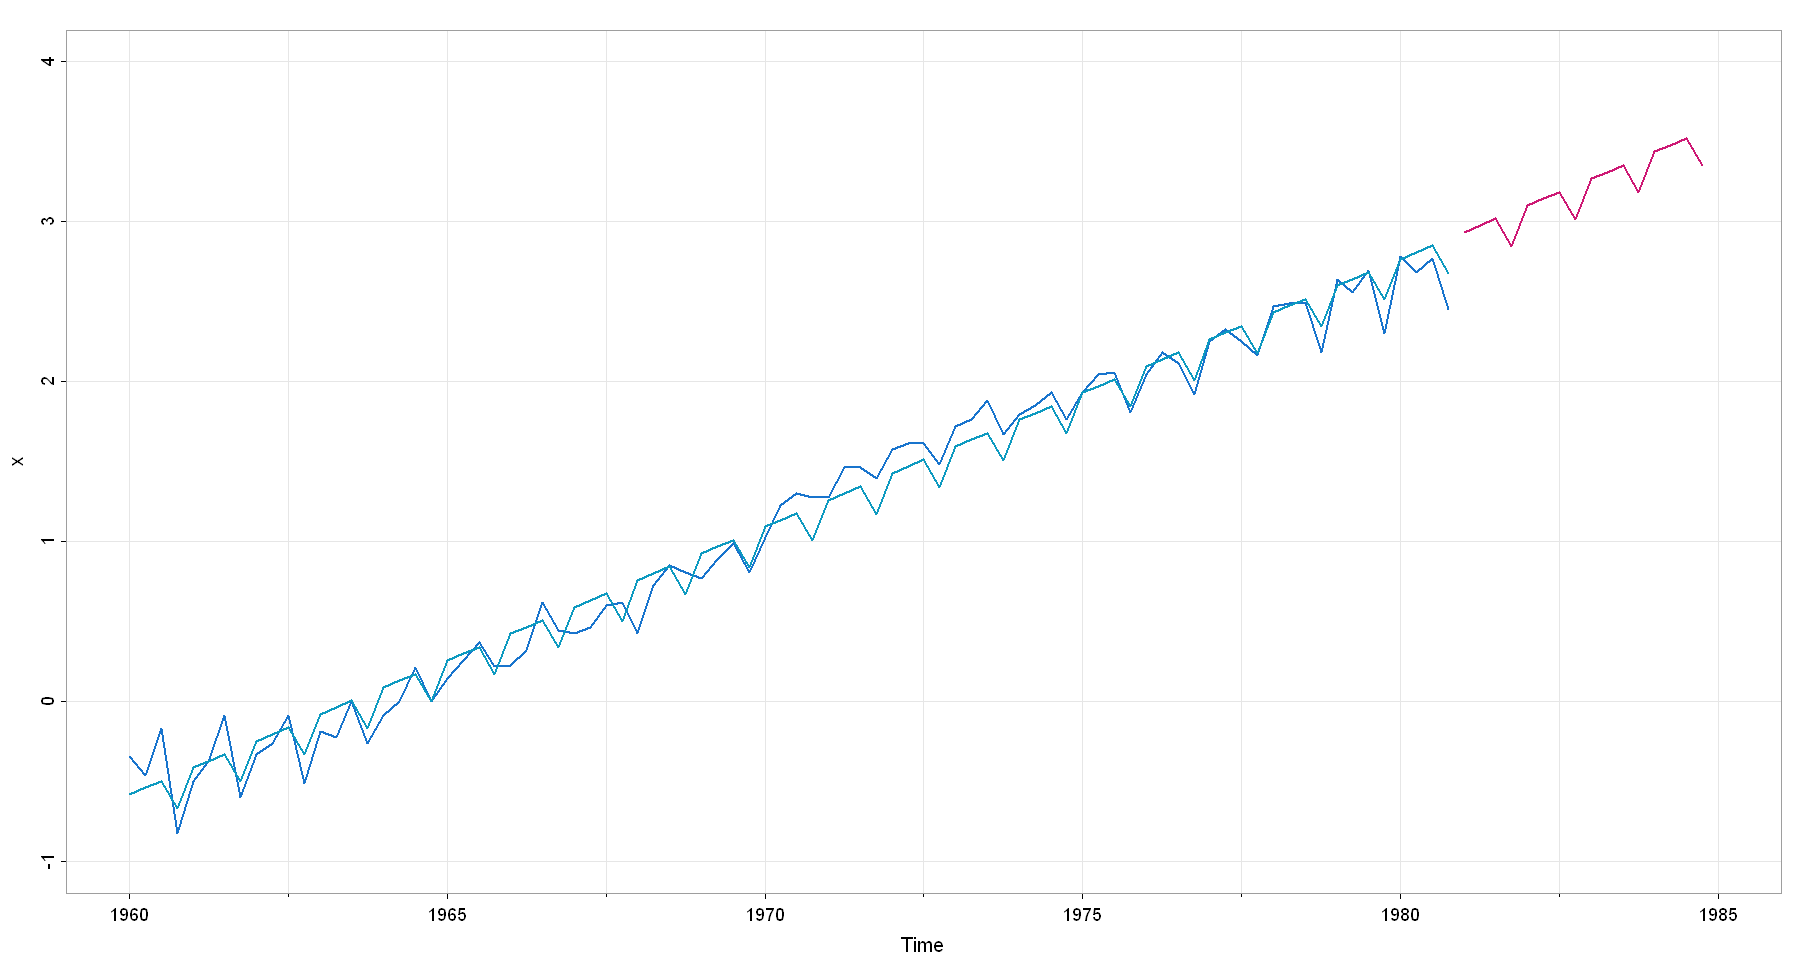

In [25]:
tsplot(x,xlim=c(1960,1985),ylim=c(-1,4), col=4, lwd=2)
lines(ajuste2,col=5, lwd=2)
lines(prediccion2,col=6, lwd=2)

,Qtr1,Qtr2,Qtr3,Qtr4
1981,18.83286,19.63744,20.47640,17.25979
1982,22.26337,23.21451,24.20629,20.40376
1983,26.31877,27.44316,28.61560,24.12042
1984,31.11287,32.44209,33.82809,28.51408


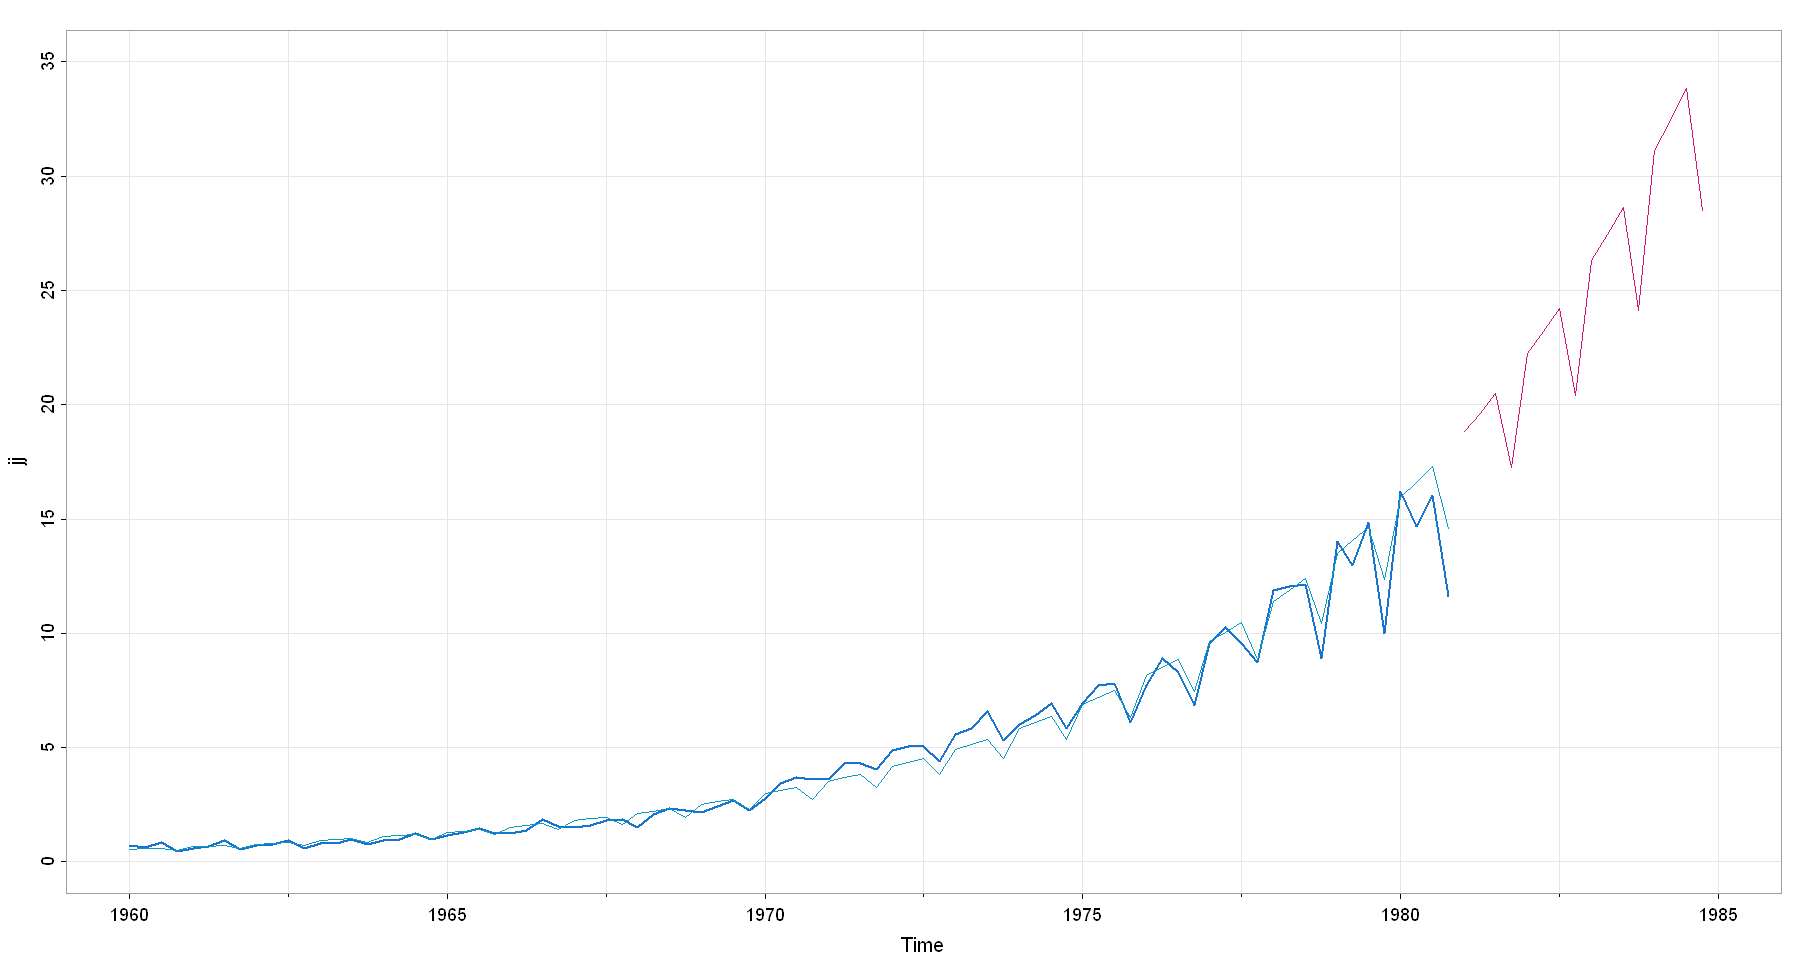

In [26]:
ajuste_original_2 = exp(ajuste2)
pred_original_2 = exp(prediccion2)

tsplot(jj,xlim=c(1960,1985),ylim=c(0,35), col=4, lwd=2)
lines(ajuste_original_2,col=5)
lines(pred_original_2,col=6)
pred_original_2

### Trabajando con los residuos

Continuemos explorando el modelo 2, que tiene solo una variable para el trimestre 4. Pasemos a analizar los residuos y hagamos un ajuste completo, para luego llevarlo a la serie original.

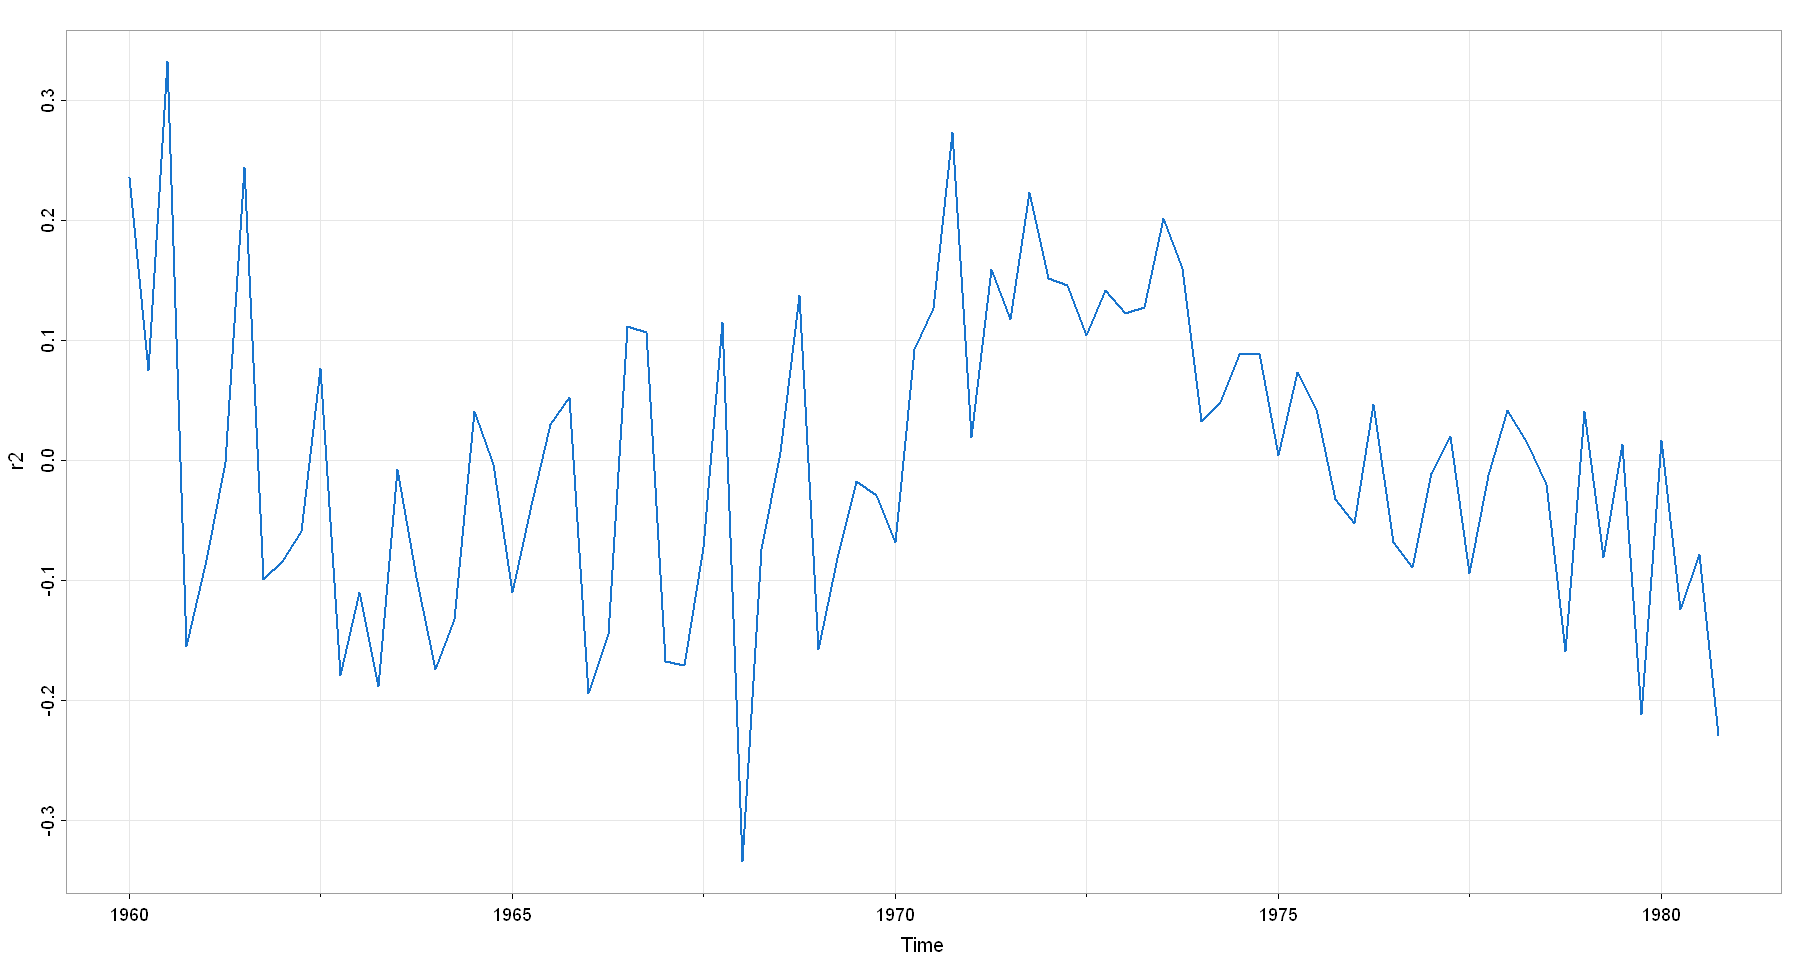

In [27]:
tsplot(r2, lwd=2, col=4)

Analicemos la ACF y PACF

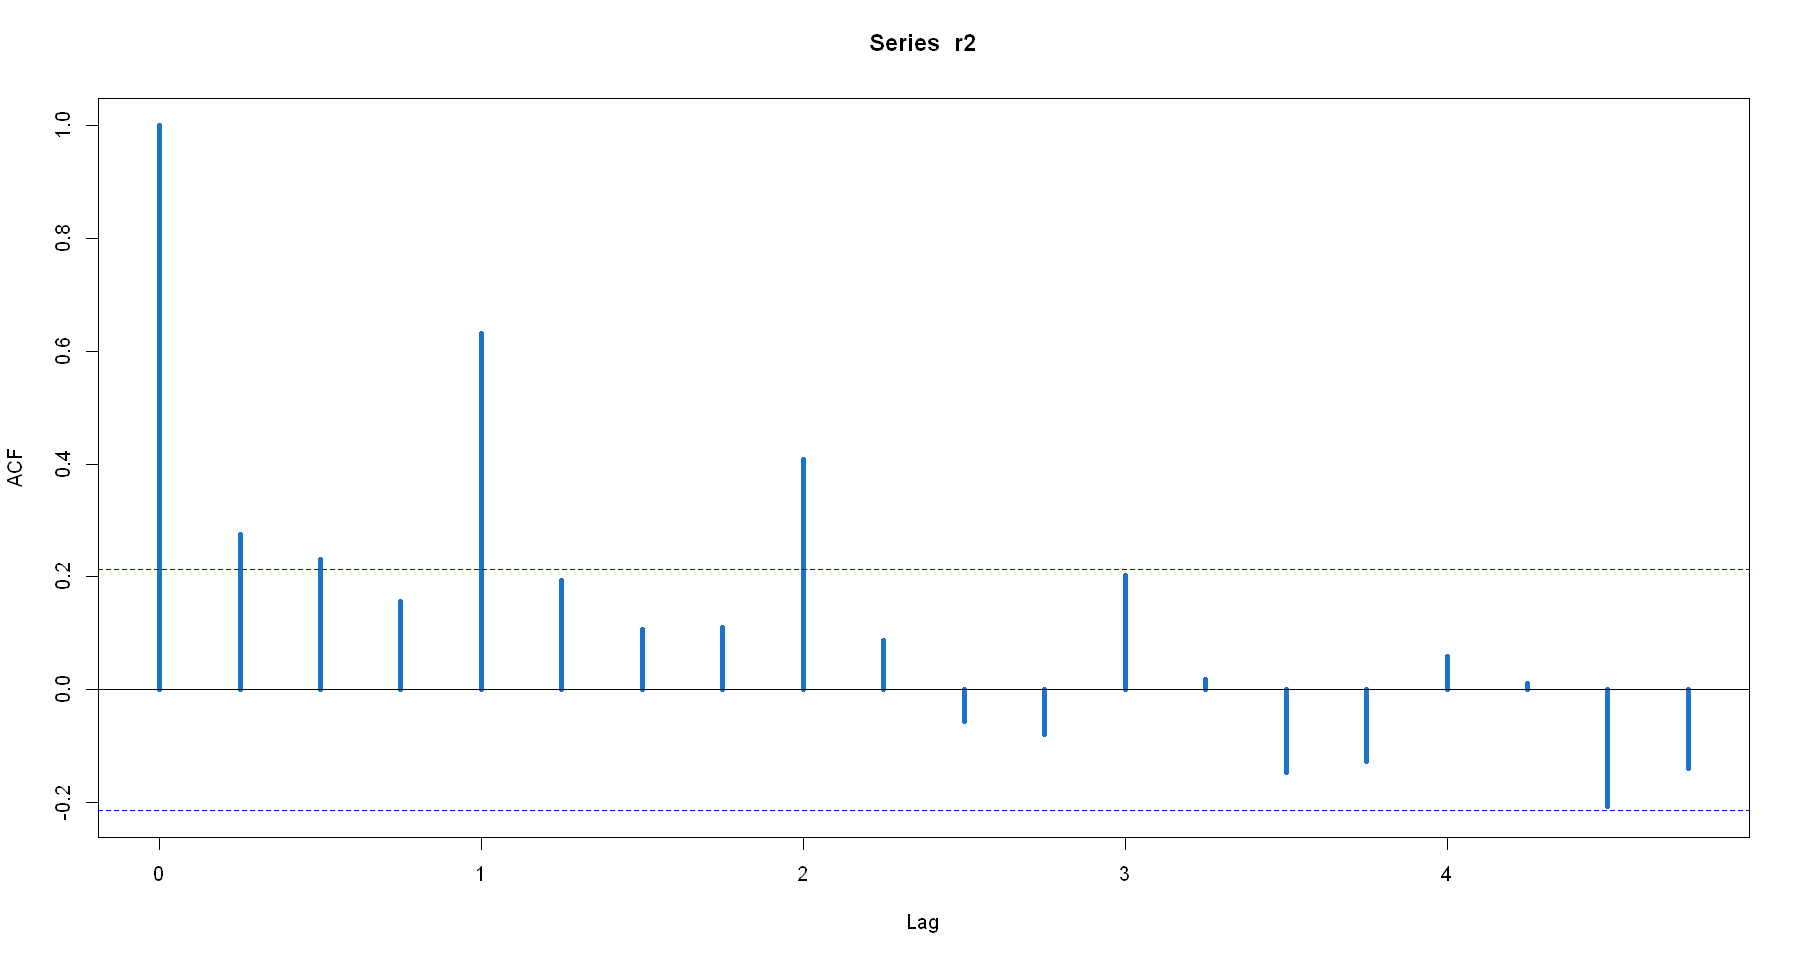

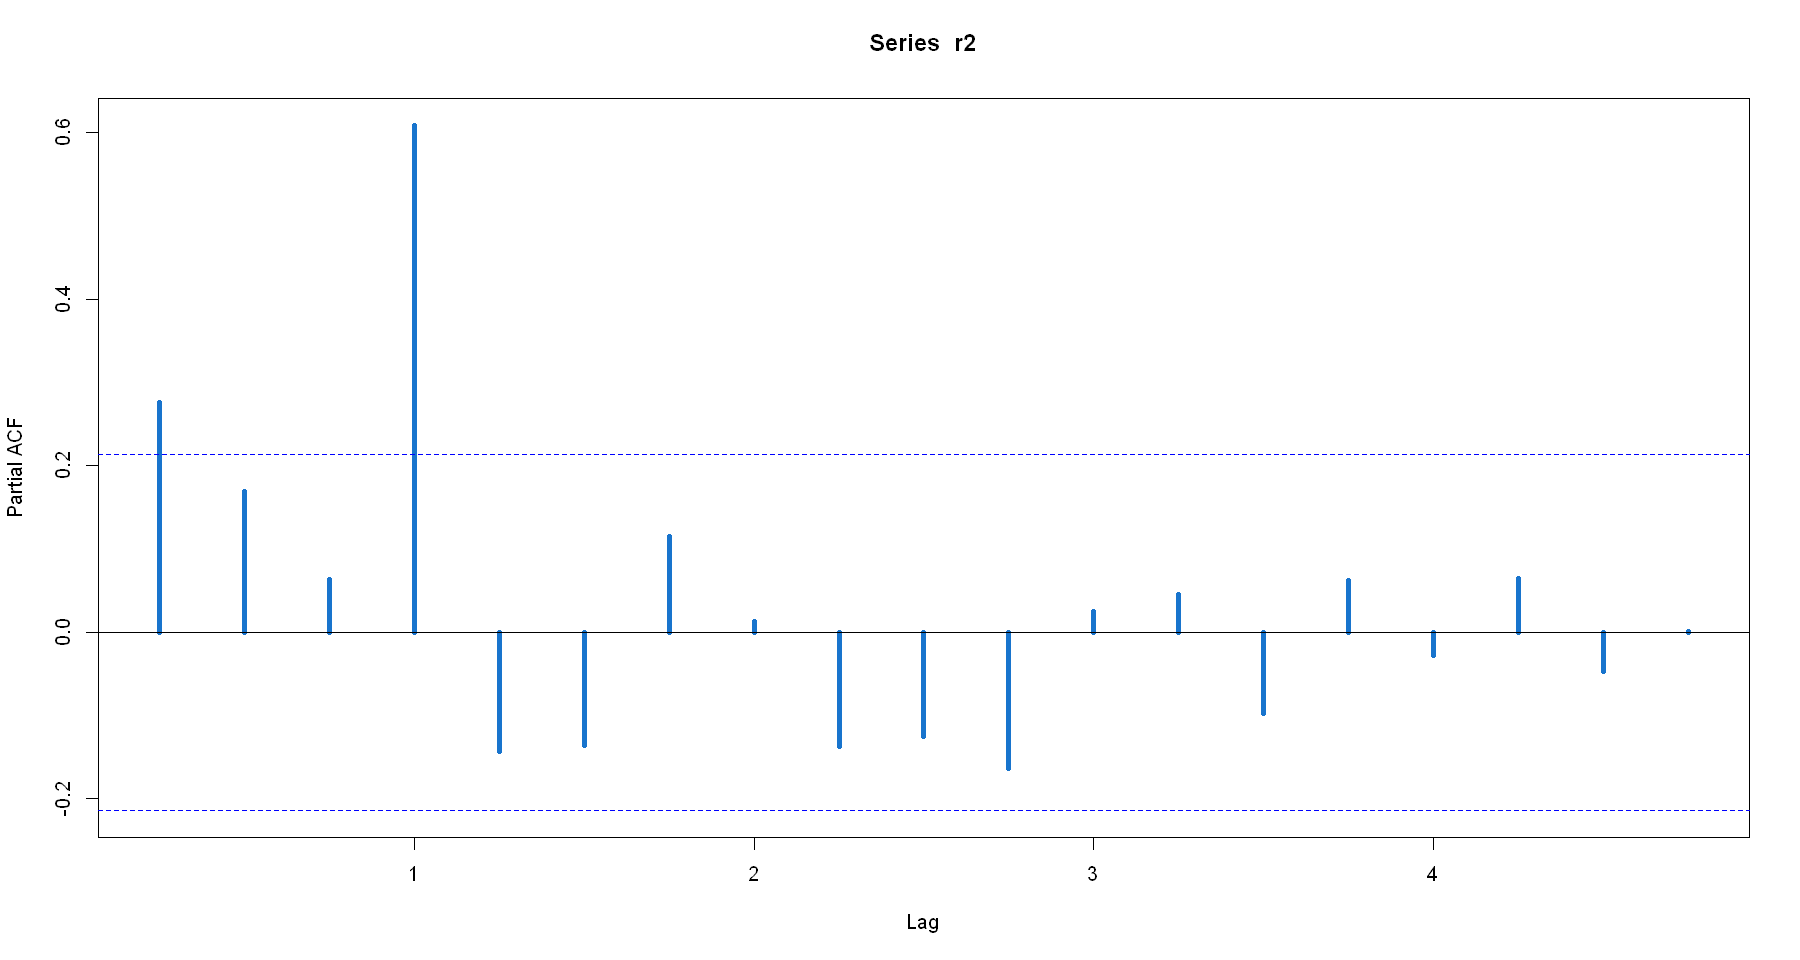

In [29]:
acf(r2, lwd=4, col=4)
pacf(r2, lwd=4, col=4)

Si bien la PACF no es clara, vemos que la ACF decae exponencialmente (con una fuerte componente cada 4 lags, es decir, anual). La PACF corta luego del 4 así que podemos probar con un modelo $AR(4)$. Aquí conviene por simplicidad el comando `Arima` de la biblioteca `forecast`. Puede usarse también `arima`, que es el básico de `R`.

In [30]:
#Ajusto un modelo AR(4) al residuo
#include.mean=FALSE es porque ya le sacamos la tendencia y parece estar centrada.

fit3 = Arima(r2,order=c(4,0,0),include.mean = FALSE)
summary(fit3)

Series: r2 
ARIMA(4,0,0) with zero mean 

Coefficients:
         ar1     ar2      ar3     ar4
      0.1380  0.0943  -0.0992  0.7209
s.e.  0.0777  0.0762   0.0825  0.0806

sigma^2 = 0.007922:  log likelihood = 84.45
AIC=-158.89   AICc=-158.12   BIC=-146.74

Training set error measures:
                       ME       RMSE        MAE      MPE     MAPE      MASE
Training set -0.006337326 0.08686234 0.06624306 22.67815 144.8972 0.8937077
                  ACF1
Training set 0.1504564

#### Análisis del error y residuos

Conviene comentar que es el $\sigma^2$ y el RMSE estimados por `Arima`:

* $\sigma^2$ es la varianza del ruido blanco que genera el Arima. A menor varianza mejor, pero este **no es el error de predicción**.
* RMSE es el **error cuadrático medio de predicción**. Lo que hace aquí es realizar la mejor predicción posible usando el modelo ajustado de los valores de la serie y considerar la varianza del error cometido en la predicción. De nuevo, queremos el menor RMSE posible.


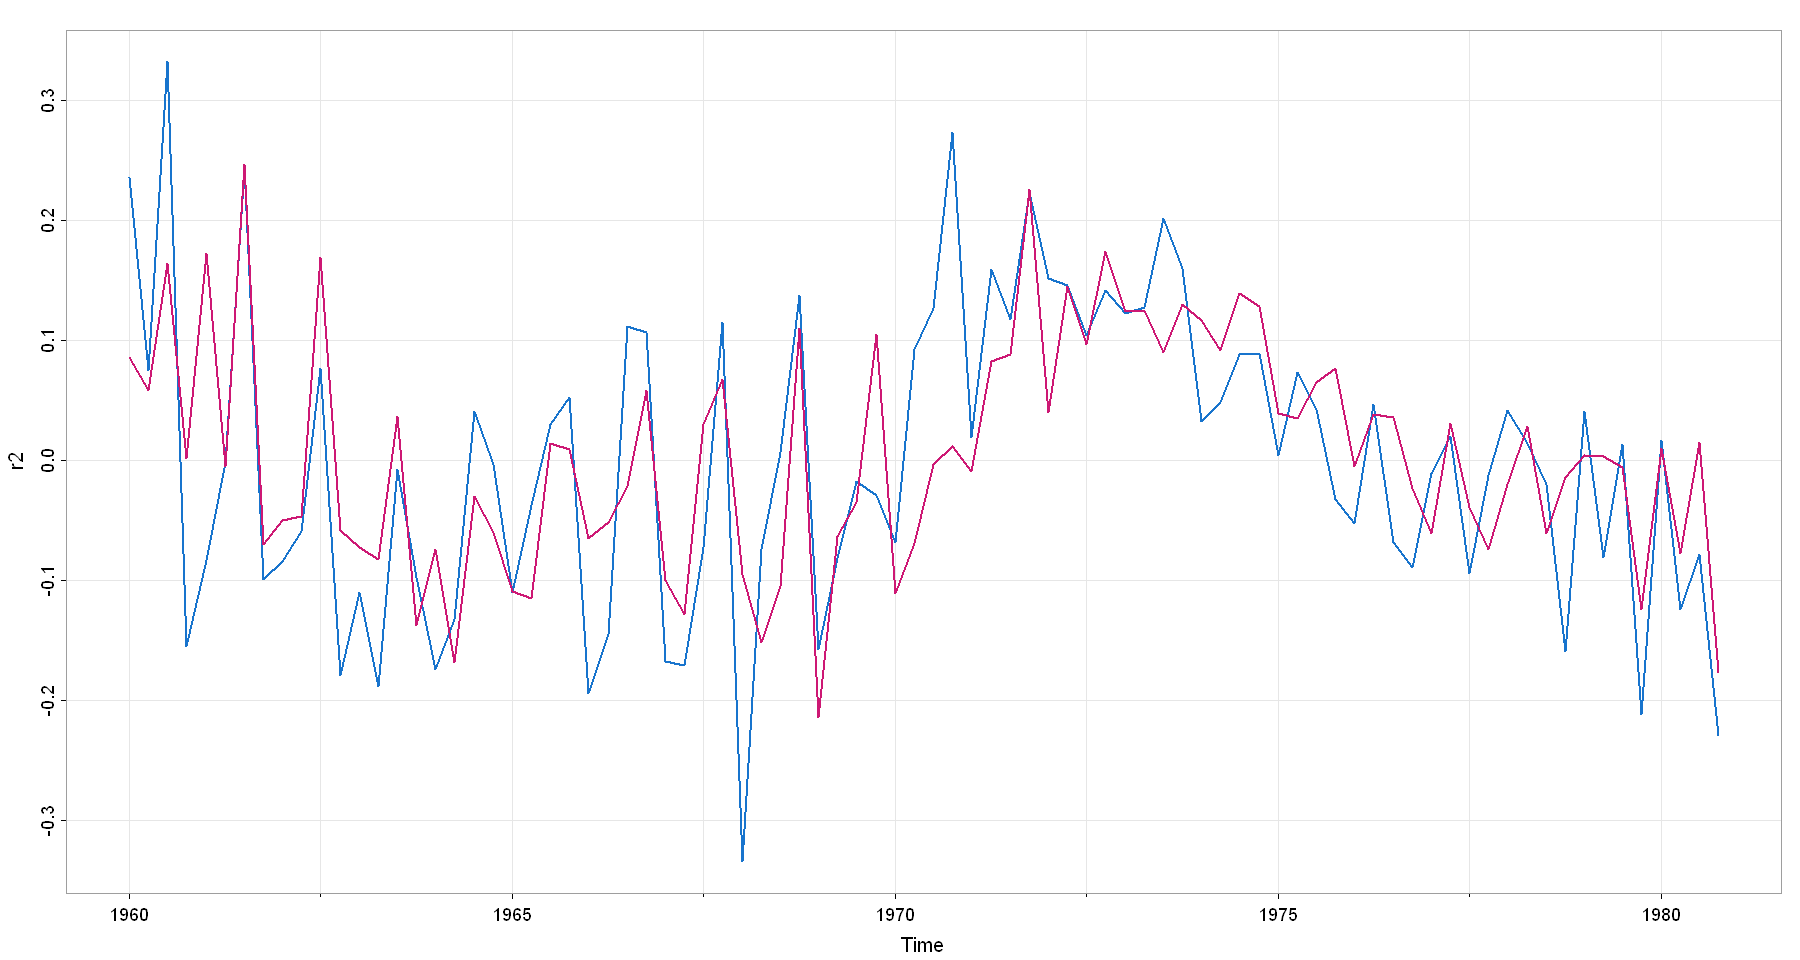

In [31]:
tsplot(r2, col=4, lwd=2)

#Notar que el ajuste de Arima preserva la time series, por lo que no tengo que reconstruir los tiempos
ajuste3 = fitted(fit3)
lines(ajuste3,col=6, lwd=2)

In [32]:
#Calculo el desvio estandar de los residuos para ver que coincide con el RMSE
#La diferencia radica en como considera los grados de libertad en el denominador
#Esta diferencia es mínima para un no. grande de datos
sd(r2-ajuste3)

[1] 0.08715116

In [33]:
#Si hacemos r2-ajuste lo que estamos obteniendo es residuals(fit) por lo que esto da lo mismo
RMSE3 = sd(residuals(fit3))
RMSE3

[1] 0.08715116

### Incluyendo la predicción del ARIMA

Resta ahora ver cómo incluir la predicción del ARIMA a futuro en la predicción global. Nuevamente debemos deshacer los cambios de variable. Comencemos haciendo la predicción solo de la parte autorregresiva. Para ello volvemos a usar `forecast`

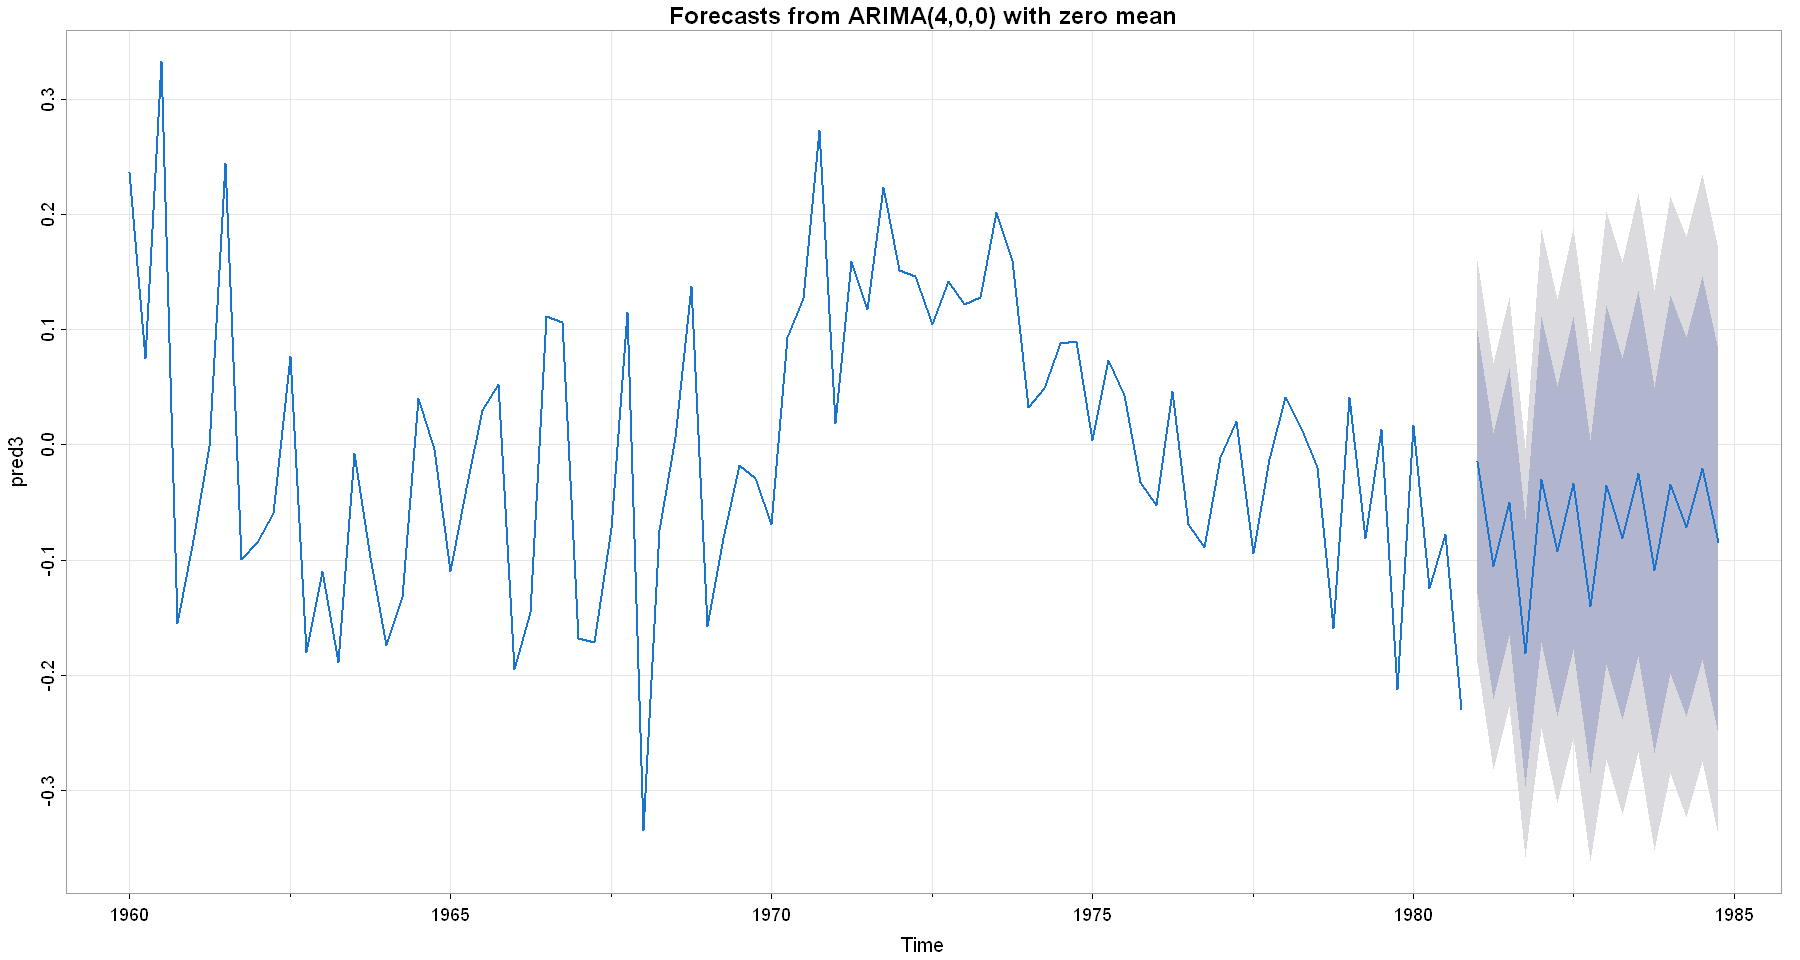

In [34]:
#Hacemos una predicción 4 años para adelante

pred3 = forecast(fit3,h=16)

tsplot(pred3, col=4, lwd=2)

El objeto `pred3` incluye las predicciones y el intervalo de confianza. Para recuperar la serie original tenemos que sumarle los trend y season4 ya ajustados y además volver de `x=log(jj)` a `jj=exp(x)`. Para ello podemos hacer lo siguiente: 

In [35]:
#Analicemos pred3
pred3

        Point Forecast      Lo 80        Hi 80      Lo 95        Hi 95
1981 Q1    -0.01460125 -0.1286688  0.099466336 -0.1890526  0.159850067
1981 Q2    -0.10549686 -0.2206461  0.009652420 -0.2816025  0.070608766
1981 Q3    -0.04951037 -0.1653839  0.066363140 -0.2267236  0.127702871
1981 Q4    -0.18055603 -0.2967083 -0.064403707 -0.3581957 -0.002916383
1982 Q1    -0.02965768 -0.1711397  0.111824331 -0.2460358  0.186720385
1982 Q2    -0.09227253 -0.2352265  0.050681417 -0.3109017  0.126356668
1982 Q3    -0.03331973 -0.1777458  0.111106385 -0.2542004  0.187560950
1982 Q4    -0.14053046 -0.2852393  0.004178381 -0.3618435  0.080782615
1983 Q1    -0.03477126 -0.1902652  0.120722683 -0.2725787  0.203036207
1983 Q2    -0.08127451 -0.2380130  0.075464002 -0.3209854  0.158436360
1983 Q3    -0.02458178 -0.1831192  0.133955591 -0.2670438  0.217880206
1983 Q4    -0.10892402 -0.2676165  0.049768477 -0.3516232  0.133775209
1984 Q1    -0.03436126 -0.1981018  0.129379331 -0.2847809  0.216058363
1984 Q

In [36]:
#Podemos extraer la media de la predicción y los extremos del intervalo de confianza al 95%
pred3_media = pred3$mean
pred3_lower = pred3$lower[,2]    #La segunda columna de lower tiene el valor del IdC al 95% por abajo
pred3_upper = pred3$upper[,2]    #La segunda columna de upper tiene el valor del IdC al 95% por arriba

#Le agregamos la prediccion con el t_new y season4_new que teniamos del fit2
pred3_media = prediccion2 + pred3_media
pred3_lower = prediccion2 + pred3_lower
pred3_upper = prediccion2 + pred3_upper


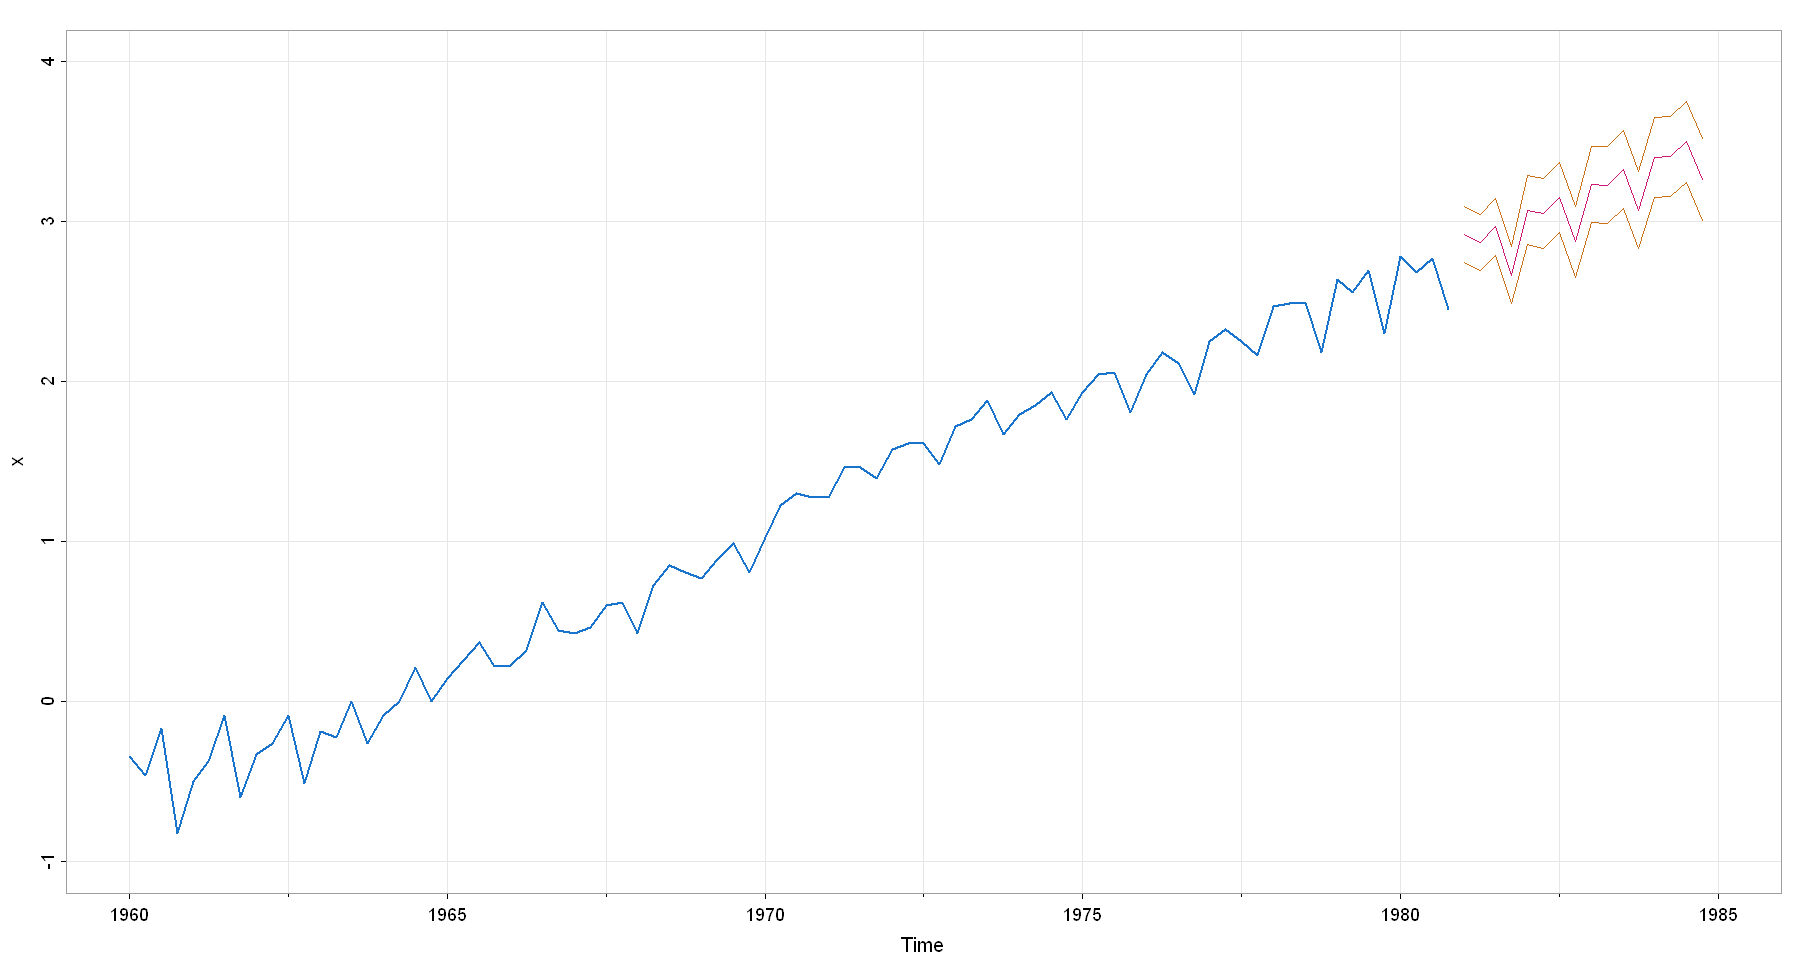

In [37]:
tsplot(x,xlim=c(1960,1985),ylim=c(-1,4), lwd=2, col=4)
lines(pred3_media,col=6)
lines(pred3_lower,col=7)
lines(pred3_upper,col=7)

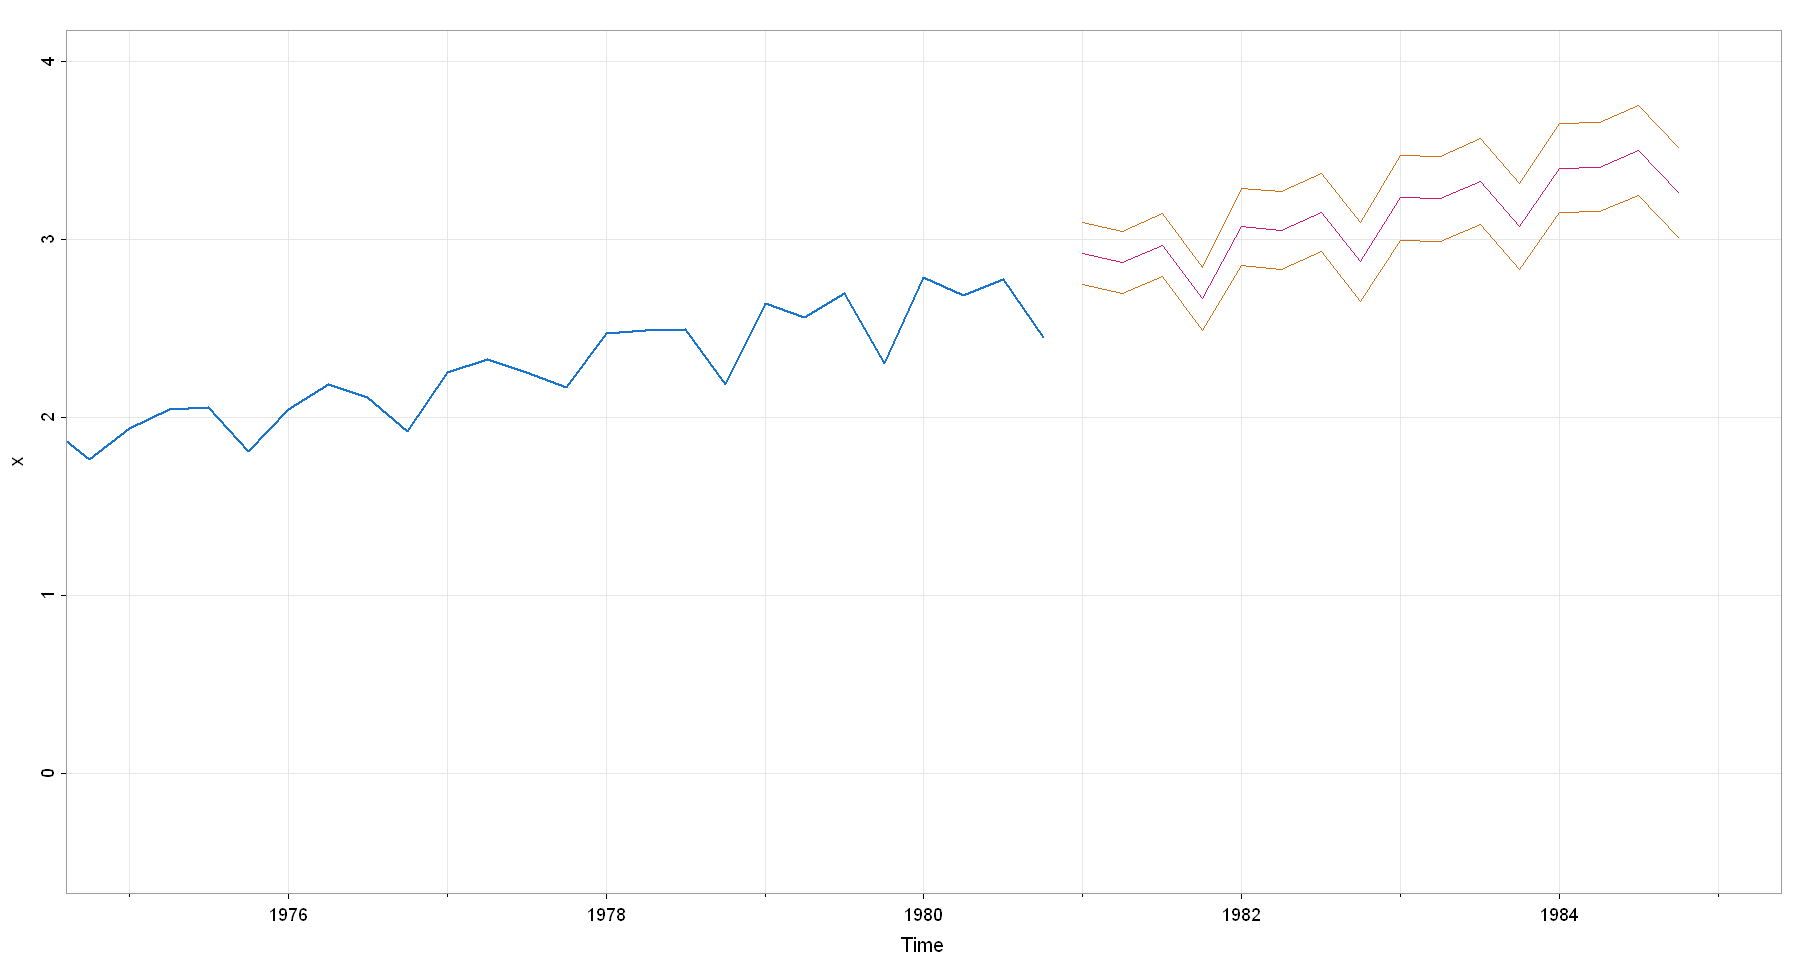

In [38]:
tsplot(x,xlim=c(1975,1985),ylim=c(-.5,4), lwd=2, col=4)
lines(pred3_media,col=6)
lines(pred3_lower,col=7)
lines(pred3_upper,col=7)

Y ahora como la transformación $x \to exp(x)$ es monótona, podemos aplicar `exp` a la media y al intervalo de confianza.

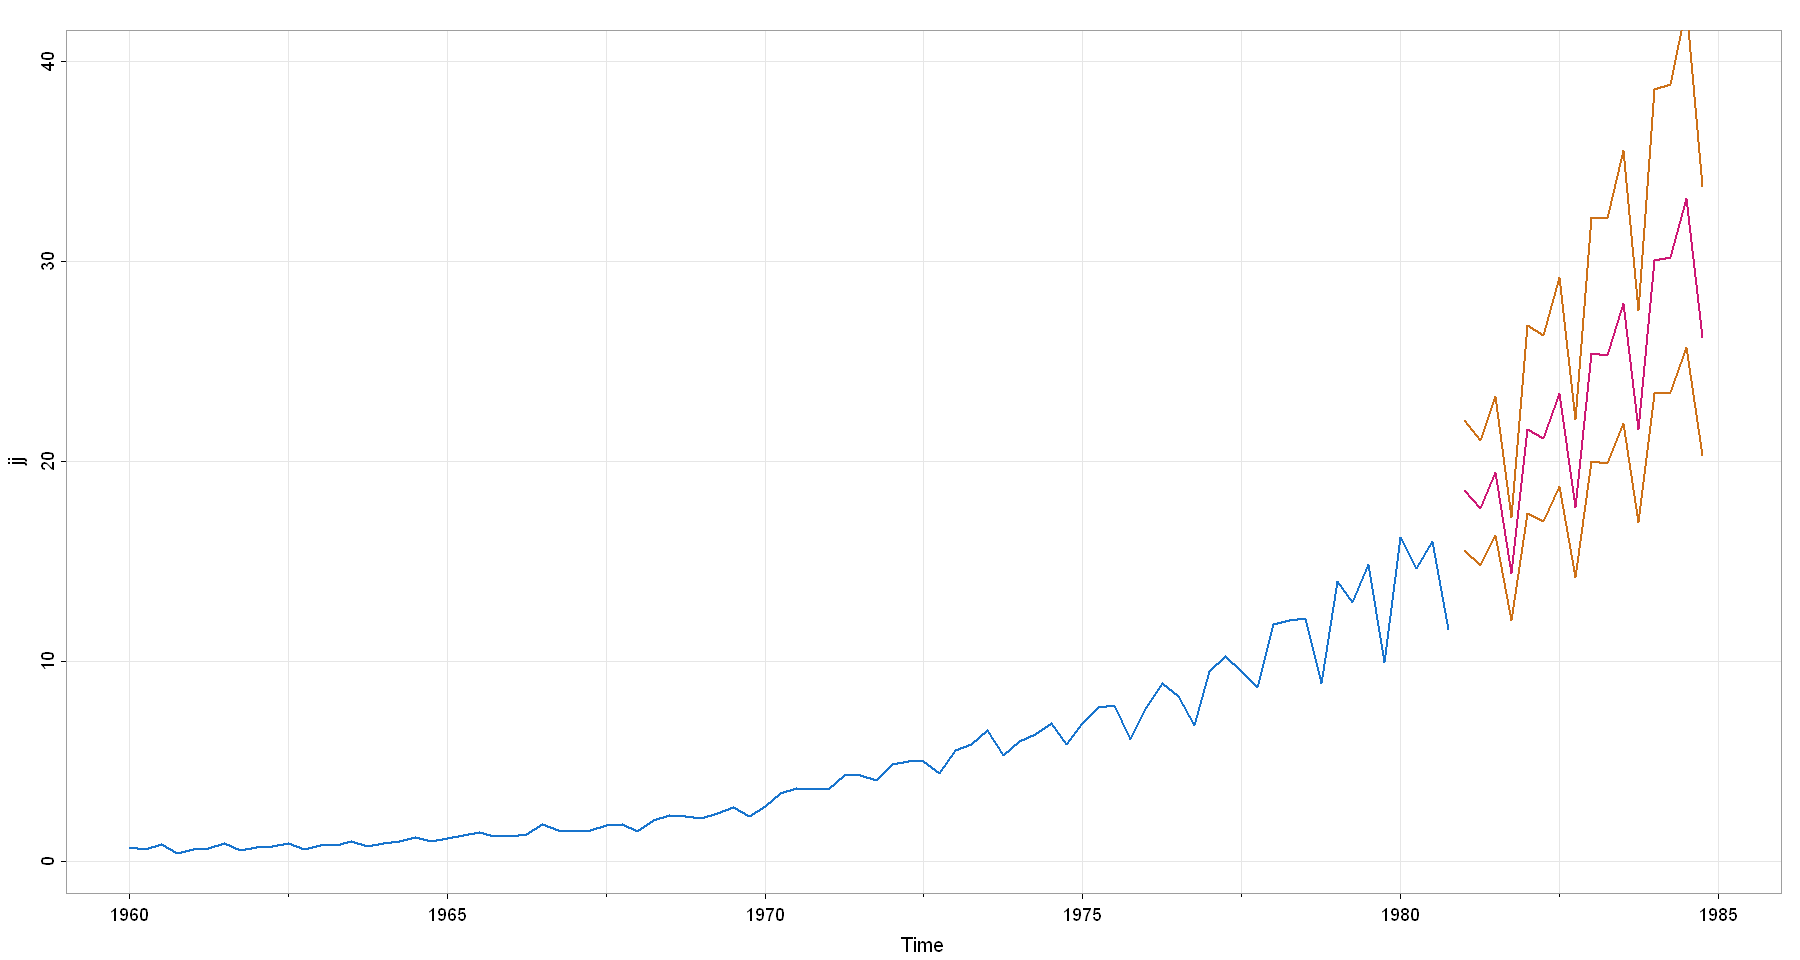

In [41]:
tsplot(jj,xlim=c(1960,1985), ylim=c(0,40), col=4, lwd=2)
lines(exp(pred3_media),col=6, lwd=2)
lines(exp(pred3_lower),col=7, lwd=2)
lines(exp(pred3_upper),col=7, lwd=2)

#### Nota sobre los intervalos de confianza:

Formalmente, el intervalo anterior asume que la varianza solo es producto de la parte AR ajustada a los residuos. En realidad también se agrega incertidumbre debido al modelo lineal ajustado para tendencia y estacionalidad. Sin embargo, no es fácil combinar ambas cosas. De todos modos en general constituye una buena estimación.

### Bonus track: ¿y si solo ajustamos un coeficiente autorregresivo con lag 4?

Revisemos el resultado del fit del Arima a la serie de residuos del fit2 (`r2`)

In [42]:
summary(fit3)

Series: r2 
ARIMA(4,0,0) with zero mean 

Coefficients:
         ar1     ar2      ar3     ar4
      0.1380  0.0943  -0.0992  0.7209
s.e.  0.0777  0.0762   0.0825  0.0806

sigma^2 = 0.007922:  log likelihood = 84.45
AIC=-158.89   AICc=-158.12   BIC=-146.74

Training set error measures:
                       ME       RMSE        MAE      MPE     MAPE      MASE
Training set -0.006337326 0.08686234 0.06624306 22.67815 144.8972 0.8937077
                  ACF1
Training set 0.1504564

El único coeficiente realmente significativo es el de lag 4 (`ar4`), ya que está a más de dos standard error (s.e.) de $0$. Podemos intentar ajustar un modelo de la forma:

$$r_t = \phi r_{t-4}$$

y olvidarnos del resto. Sin embargo, en `Arima` no podemos forzar los coeficientes a $0$. Hay que hacerlo a mano, por ejemplo mediante mínimos cuadrados con la serie laggeada.

In [43]:
dos_series = ts.intersect(r2,r2_4=lag(r2,-4))

fit4 = lm(r2~0+r2_4,data=dos_series)
summary(fit4)


Call:
lm(formula = r2 ~ 0 + r2_4, data = dos_series)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.240841 -0.060608 -0.004535  0.043341  0.292919 

Coefficients:
     Estimate Std. Error t value Pr(>|t|)    
r2_4  0.66825    0.07615   8.775 2.68e-13 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.08598 on 79 degrees of freedom
Multiple R-squared:  0.4936,	Adjusted R-squared:  0.4872 
F-statistic:    77 on 1 and 79 DF,  p-value: 2.676e-13


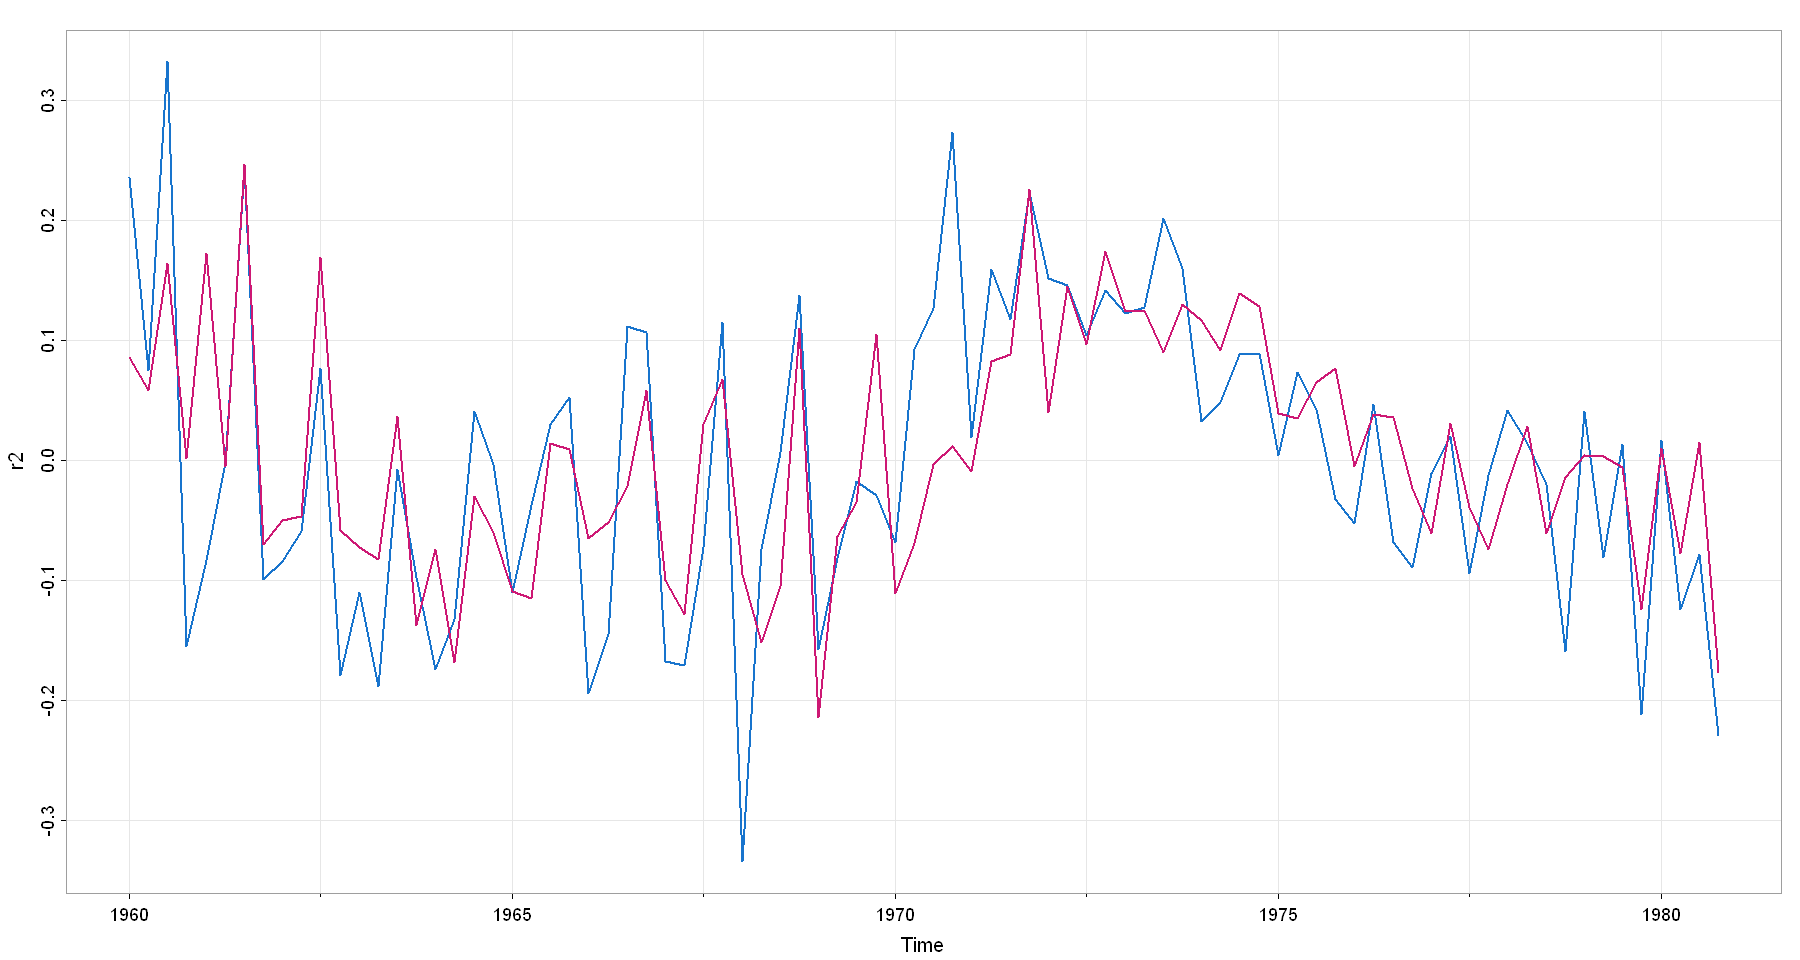

In [44]:
tsplot(r2, col=4, lwd=2)

#recupero los datos fitteados y hago una time series (como uso lm, aquí no se hace solo)
ajuste4 = fitted(fit4)
ajuste4 = ts(ajuste4,start=1960,freq=4)
lines(ajuste3,col=6, lwd=2)

In [45]:
#Calculo el RMSE de este ajuste

RMSE4 = sd(residuals(fit4))
RMSE4

[1] 0.08544457

En realidad, el fit obtenido es el mismo que ajustar un modelo SARIMA. La razón es la siguiente, al considerar solo el lag $-4$, estamos haciendo un modelo autorregresivo donde lo único que importa es el valor de 1 año atrás (la misma season) y nada más. El modelo SARIMA permite hacer esto. Los parámetros son:

* $p,d,q$ orden de la parte AR, I y MA de los lags "corridos" (los normales). En este caso son 0
* $P,D,Q$ orden de la parte AR, I y MA de los lags a un ciclo (los que solo consideran la misma estación. EN este caso P=1 (miramos la misma estación anterior).
* $S$ cantidad de estaciones. 4 en este caso.

Podemos ajustar este modelo con `forecast` usando nuevamente `Arima` y pasandole los datos de estacionalidad.

In [46]:
fit5=Arima(r2, order = c(0, 0, 0), seasonal = c(1, 0, 0), include.mean=FALSE)
summary(fit5)

Series: r2 
ARIMA(0,0,0)(1,0,0)[4] with zero mean 

Coefficients:
        sar1
      0.7404
s.e.  0.0783

sigma^2 = 0.008183:  log likelihood = 81.56
AIC=-159.12   AICc=-158.98   BIC=-154.26

Training set error measures:
                       ME      RMSE        MAE      MPE     MAPE      MASE
Training set -0.005560172 0.0899199 0.06932803 68.19435 175.3113 0.9353279
                  ACF1
Training set 0.2945933

**Nota:** La pequeña diferencia en el coeficiente obtenido para `sar1` (0.7404) y `r2_4` (0.66825) es que Arima utiliza máxima verosimilitud para mejorar el ajuste de mínimos cuadrados como el que hicimos antes.

In [47]:
pred5 = forecast(fit5,h=16)
pred5

        Point Forecast      Lo 80       Hi 80      Lo 95      Hi 95
1981 Q1    0.012399926 -0.1035292  0.12832903 -0.1648983 0.18969819
1981 Q2   -0.092028575 -0.2079577  0.02390053 -0.2693268 0.08526969
1981 Q3   -0.057822771 -0.1737519  0.05810633 -0.2351210 0.11947549
1981 Q4   -0.169682224 -0.2856113 -0.05375312 -0.3469805 0.00761604
1982 Q1    0.009181025 -0.1350660  0.15342807 -0.2114258 0.22978784
1982 Q2   -0.068138846 -0.2123859  0.07610820 -0.2887457 0.15246797
1982 Q3   -0.042812538 -0.1870596  0.10143450 -0.2634194 0.17779428
1982 Q4   -0.125634358 -0.2698814  0.01861268 -0.3462412 0.09497246
1983 Q1    0.006797720 -0.1508291  0.16442451 -0.2342716 0.24786709
1983 Q2   -0.050450660 -0.2080774  0.10717613 -0.2915200 0.19061871
1983 Q3   -0.031698817 -0.1893256  0.12592797 -0.2727682 0.20937055
1983 Q4   -0.093020893 -0.2506477  0.06460589 -0.3340903 0.14804847
1984 Q1    0.005033097 -0.1594674  0.16953357 -0.2465487 0.25661487
1984 Q2   -0.037354156 -0.2018546  0.12714632 -0

In [48]:
#Podemos extraer la media de la predicción y los extremos del intervalo de confianza al 95%
pred5_media = pred5$mean
pred5_lower = pred5$lower[,2]    #La segunda columna de lower tiene el valor del IdC al 95% por abajo
pred5_upper = pred5$upper[,2]    #La segunda columna de upper tiene el valor del IdC al 95% por arriba

#Le agregamos la prediccion con el t_new y season4_new que teniamos del fit2
pred5_media = prediccion2 + pred5_media
pred5_lower = prediccion2 + pred5_lower
pred5_upper = prediccion2 + pred5_upper


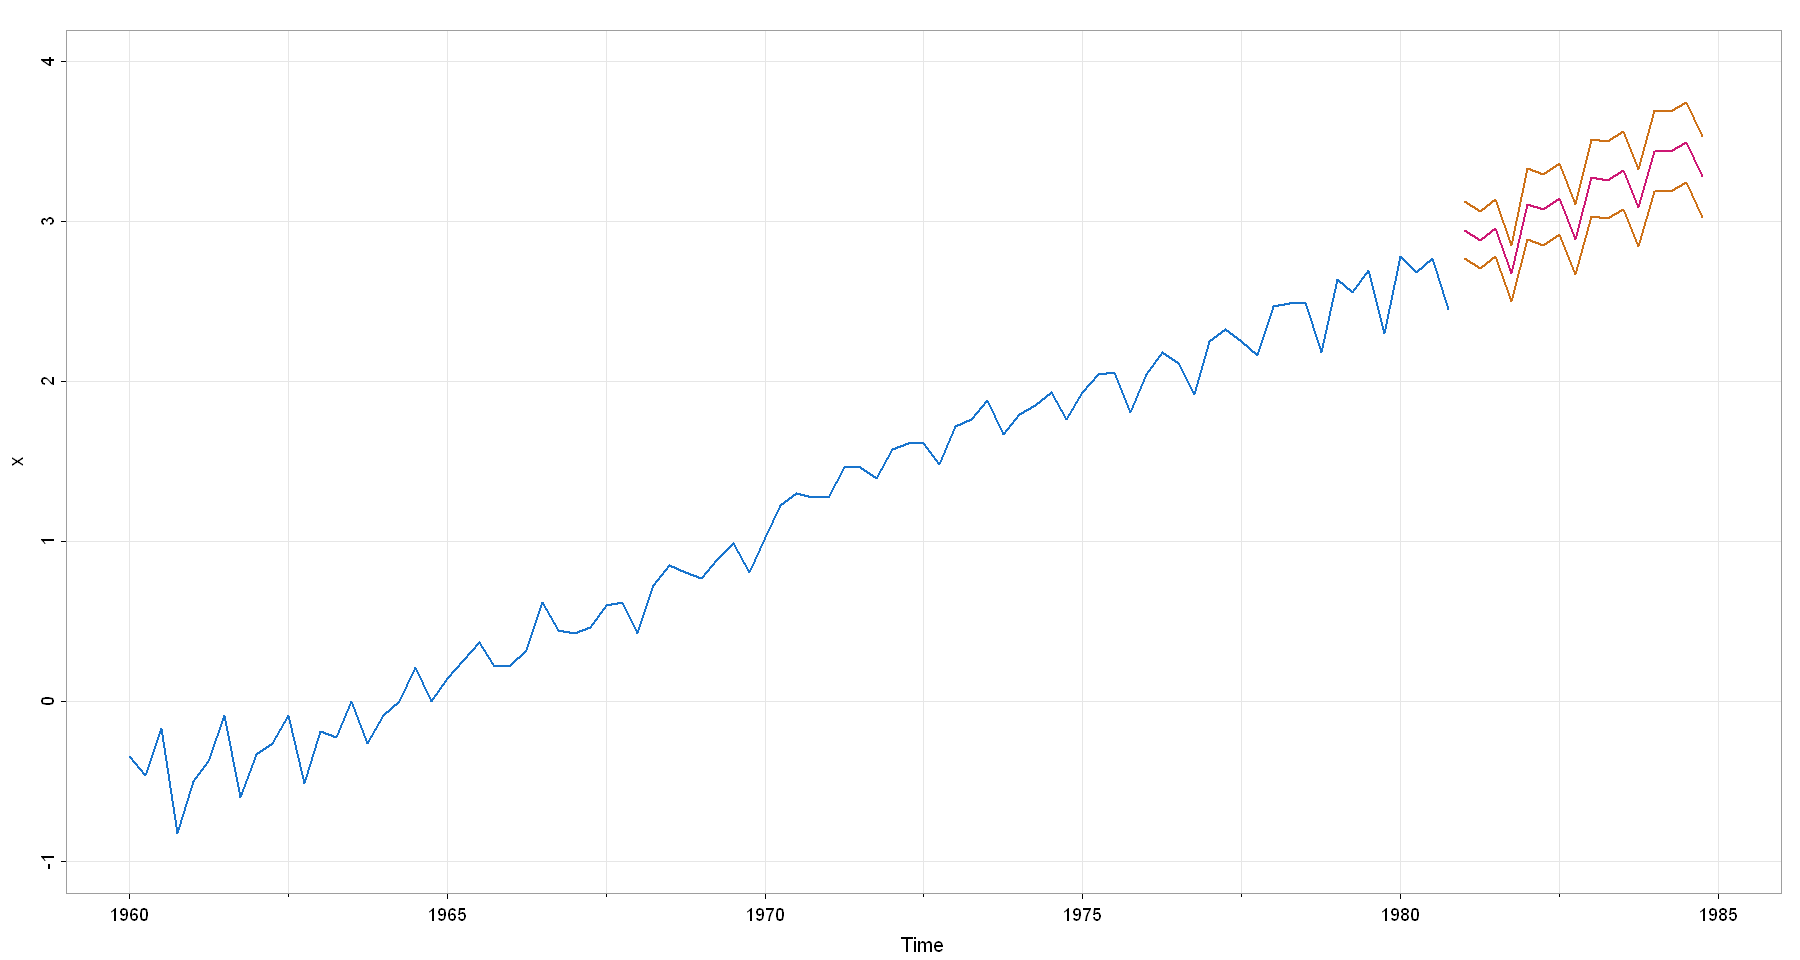

In [49]:
tsplot(x,xlim=c(1960,1985),ylim=c(-1,4), lwd=2, col=4)
lines(pred5_media,col=6, lwd=2)
lines(pred5_lower,col=7, lwd=2)
lines(pred5_upper,col=7, lwd=2)

Comparemos con la predicción del modelo 3 (es decir trend+season4+AR(4))

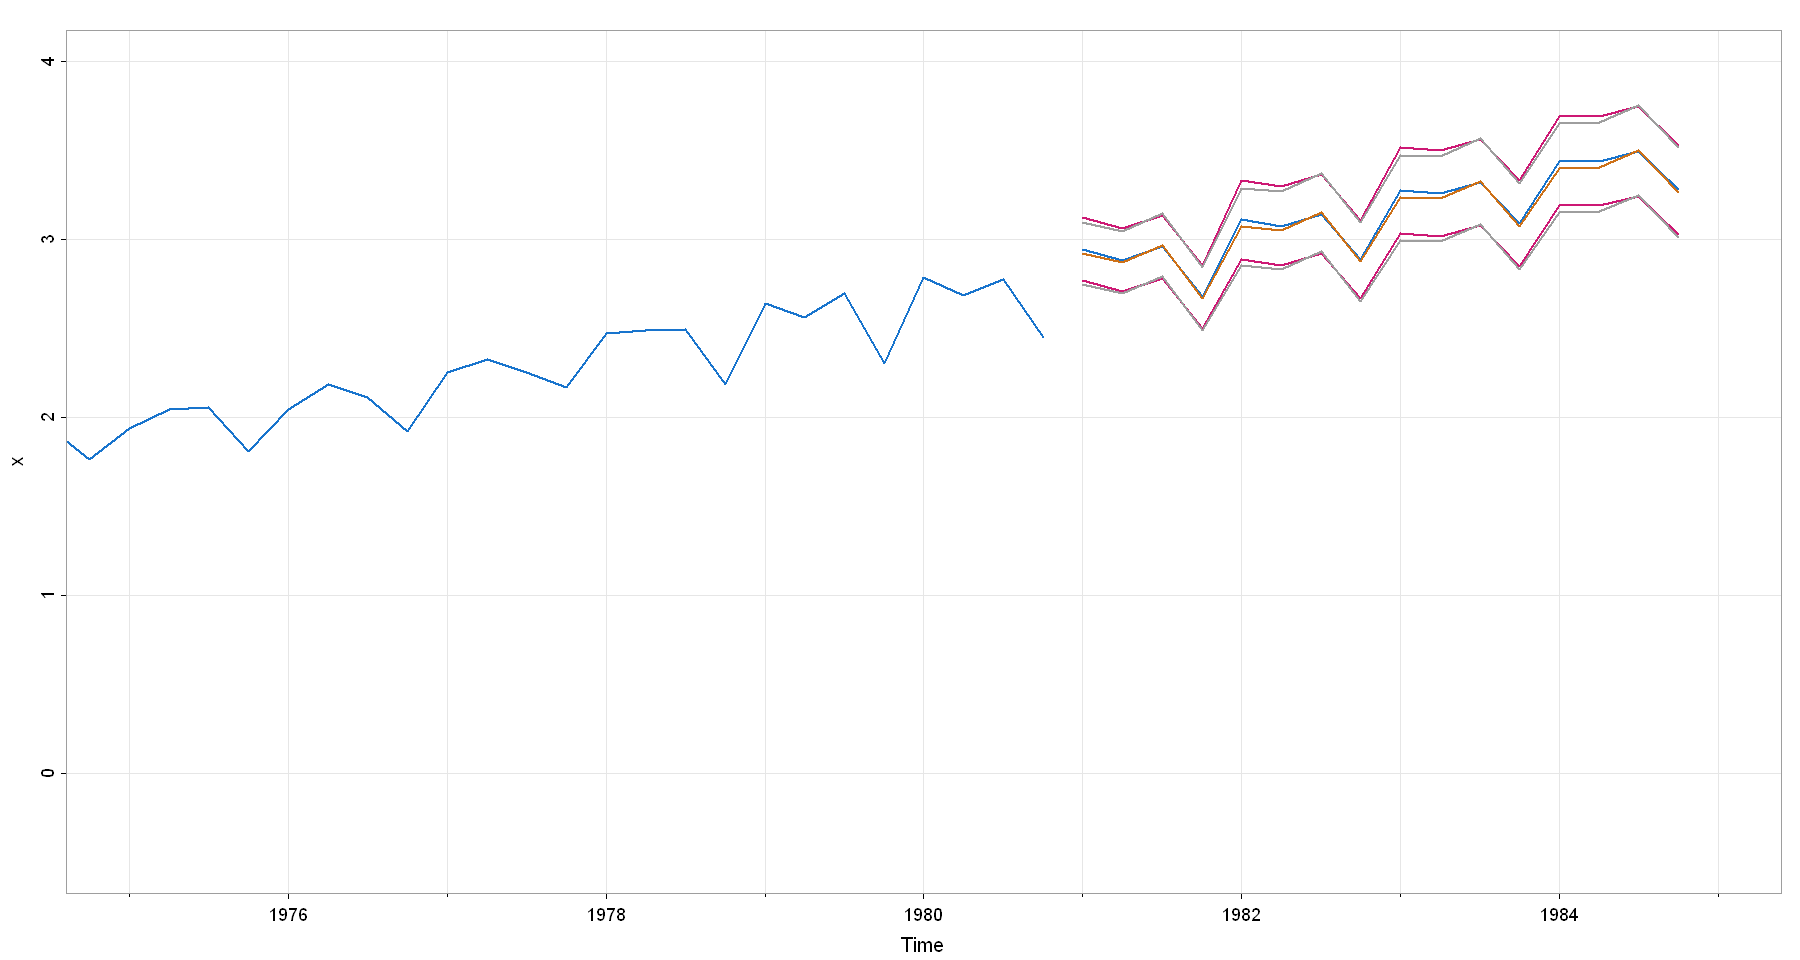

In [50]:
tsplot(x,xlim=c(1975,1985),ylim=c(-.5,4), col=4, lwd=2)
lines(pred5_media,col=4, lwd=2)
lines(pred5_lower,col=6, lwd=2)
lines(pred5_upper,col=6, lwd=2)
lines(pred3_media,col=7, lwd=2)
lines(pred3_lower,col=8, lwd=2)
lines(pred3_upper,col=8, lwd=2)

Como vemos, el resultado es similar pero usando menos parámetros. De hecho el error estándar de predicción en cada modelo es:

In [51]:
RMSE5 = sd(residuals(fit5))
RMSE3
RMSE5

[1] 0.08715116

[1] 0.09028686

Es decir, casi el mismo RMSE, pero utilizando:
* 1 intercept + 1 trend + 1 dummy season 4 + 4 coef. AR = 7 parámetros en el modelo con AR(4)
* 1 intercept + 1 trend + 1 dummy season 4 + 1 coef. AR = 4 parámetros en el SARIMA(0,0,0)(1,0,0)[4]

A todas luces, el segundo modelo parece más razonable. Podemos calcular el AIC sugerido por el libro.

In [52]:
n=length(x)

AIC3 = log(RMSE3)/n + (n+2*7)/n
AIC5 = log(RMSE5)/n + (n+2*4)/n

AIC3
AIC5

[1] 1.137618

[1] 1.06661

### Conclusión:

Si bien no comparamos todos los modelos posibles, resulta razonable pensar que el modelo final (trend + season4 + componente AR *estacional* de orden 1) es un buen modelo. 

Coloquemos la predicción en las variables originales:

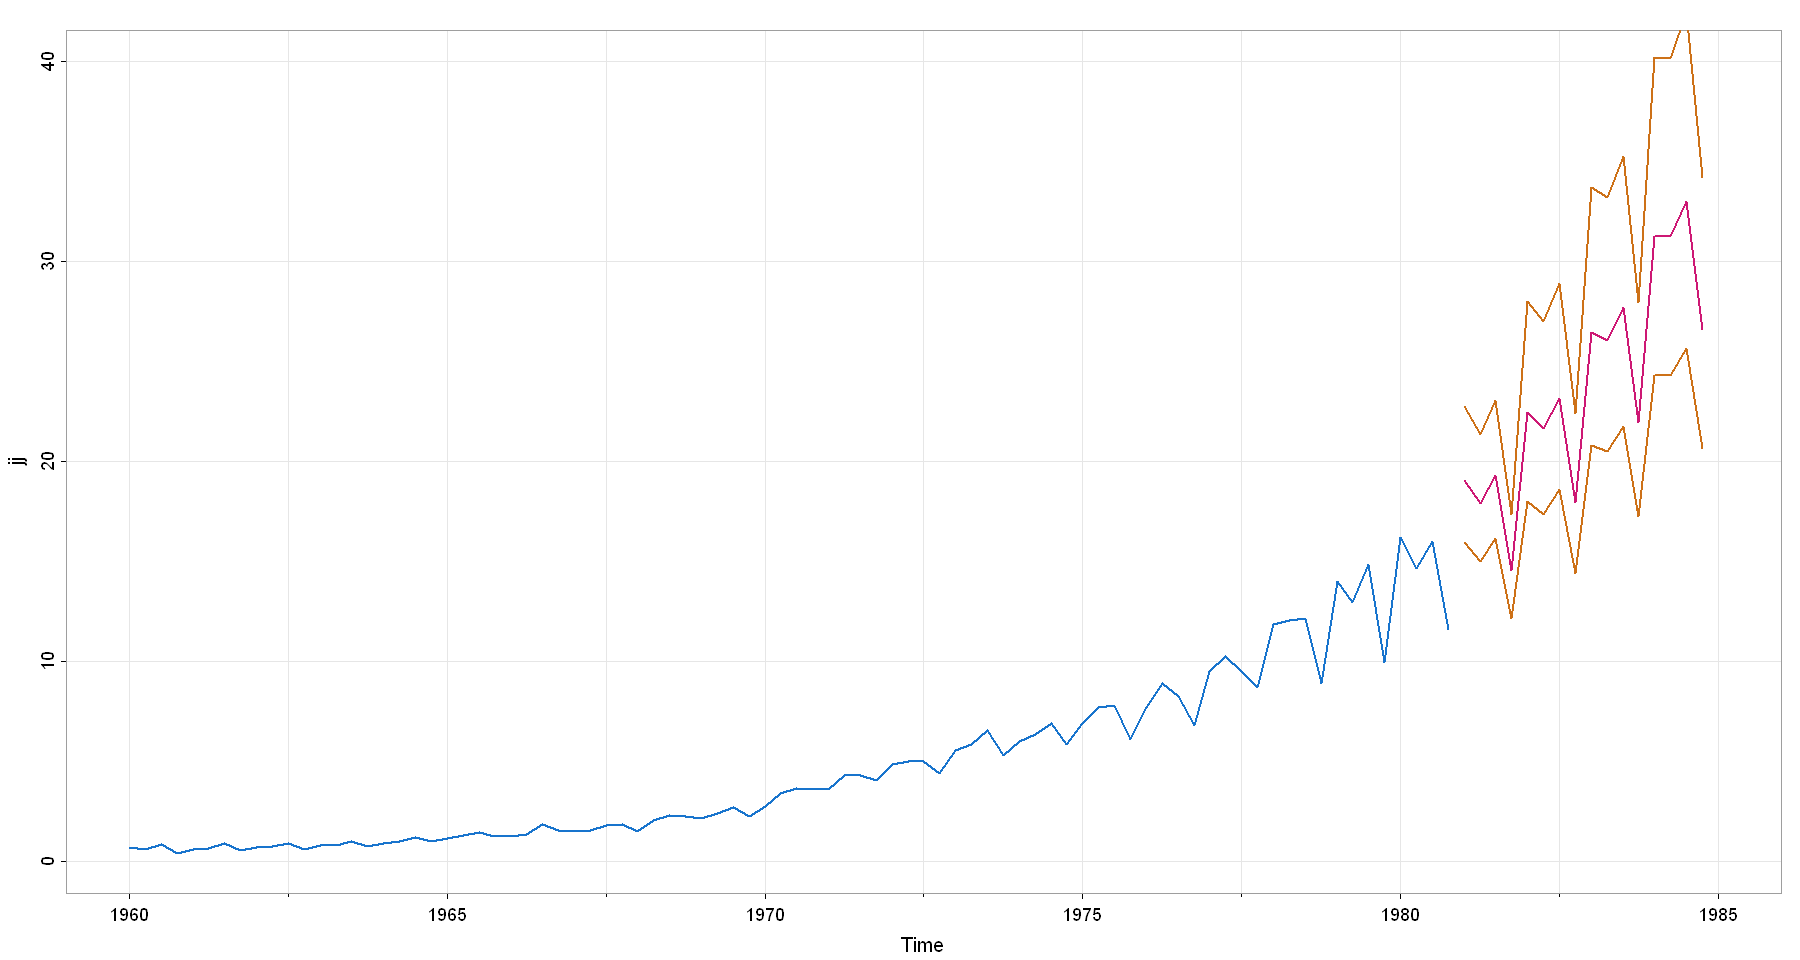

In [53]:
tsplot(jj,xlim=c(1960,1985),,ylim=c(0,40), lwd=2, col=4)
lines(exp(pred5_media),col=6, lwd=2)
lines(exp(pred5_lower),col=7, lwd=2)
lines(exp(pred5_upper),col=7, lwd=2)

### Nota: ¿y si hacemos auto.arima?

De hecho, si hacemos auto.arima el `R` encuentra como modelo un SARIMA(1,0,0)(1,0,0)\[4\], es decir:

$$r_t  = \phi_1 r_{t-1} + \Phi_1 r_{t-4}$$

Un lag para atrás, y uno un año para atrás: si volvemos a la PACF de r2 esto era una buena idea (el lag 1 era significativo también)

### Notas adicionales.

* Si en lugar de dummies se usa un ajuste por seno y coseno, la idea es la misma. Debemos reconstruir las variables sin y cos más allá del final de la serie para realizar la predicción.

* Si luego de sacar tendencia y estacionalidad por senos y cosenos ajustamos un ARIMA, podemos realizar los mismos pasos (sumar las predicciones de la parte lm con las de la parte arima) para volver a la serie original, eventualmente aplicando una transformación.

* El único caso donde esto no funciona del todo bien es cuando tenemos diff. La idea aquí es la siguiente: si para sacar componentes de tendencia hicimos diff en algún momento, y luego ajustamos un ARMA(p,q) que funciona bien (haciendo la PACF y ACF del diff para elegir el orden), entonces luego conviene pedirle a R que haga él el diff pasandole order=(p,1,q) con los p y q hallados. De este modo, ya se calculan las predicciones (en particular los intervalos de confianza) sobre la serie sin diferenciar.